**ADVANCED MACHINE LEARNING PROJECT**

Authors:
* Biasco Anna Marika      mat. 865873
* Pulerà Francesca        mat. 870005
* Zarantonello Massimo    mat. 866457

# Introduction

This project addresses the **Mercari Price Suggestion Challenge**, which aims to build a machine learning model that can automatically predict online product prices based on the following user-provided data:

* Product Name: A short descriptive title.
+ Product Category: Three-level structured categorizations.
+ Brand: Optional, specifies the name of the manufacturer or designer.
+ Item Condition: A numeric value from 1 (new) to 5 (used).
* Textual Description: A description provided by users.

Product price prediction is useful for assisting online retailers in setting competitive prices, thus improving the customer experience and facilitating the decision-making process.

## Objective

The main goal of this notebook is:

* **Analyze** the data provided, understanding its distribution and peculiarities.
* **Preprocess** the data and design useful features for the model.
* **Build** a machine learning model to predict the price of products with high accuracy.
* **Evaluate** the performance of the model through appropriate metrics.

The official dataset was provided by the Kaggle competition (https://www.kaggle.com/c/mercari-price-suggestion-challenge/data), and is composed of a set of 1.5 million rows of data, each containing the details described above.

## What is Mercari?

Mercari is a popular online marketplace founded in Japan in 2013 that allows users to buy and sell a wide range of products, from clothing to household items, electronics and more. The platform stands out for its ease of use, allowing sellers to quickly post listings, with just a few details such as the title, description, category and product images.

The challenge of predicting prices is particularly relevant for Mercari, as it helps sellers set competitive and attractive prices in a market where there are thousands of similar items. Improving the accuracy of price suggestions not only optimizes the user experience but also contributes to the fluidity of transactions on the platform.



In [ ]:
import sys
print(sys.executable)

/home/MindHard/miniconda3/envs/AML/bin/python


In [ ]:
# importations
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway, ttest_ind, pearsonr
from scipy.sparse import hstack, csr_matrix, save_npz, load_npz

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization, GRU,  # type: ignore
                                     LSTM, Bidirectional, Embedding, Reshape, concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K

import eli5
from sklearn.model_selection import KFold
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_absolute_error

import scipy.sparse as sp
from lime.lime_tabular import LimeTabularExplainer

2025-02-06 08:34:41.847992: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 08:34:41.894385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 08:34:41.894426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 08:34:41.895886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 08:34:41.903137: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 08:34:41.904096: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
anna_path = '/content/drive/MyDrive/Magistrale/2°anno/Advanced ML/Advanced Machine Learning/train.tsv'
fra_path = 'train.tsv'
#fra_path = '/content/drive/MyDrive/Advanced Machine Learning/train.tsv'
max_path = ''

if os.path.exists(anna_path):
    df = pd.read_csv(anna_path, sep='\t')
elif os.path.exists(fra_path):
    df = pd.read_csv(fra_path, sep='\t')
elif os.path.exists(max_path):
    df = pd.read_csv(max_path, sep='\t')
else:
    print("File not found")

In [ ]:
df.head()

train_id                                 name  item_condition_id   
0         0  MLB Cincinnati Reds T Shirt Size XL                  3  \
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price   
0                                  Men/Tops/T-shirts        NaN   10.0  \
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

## Dataset composition


- **train_id** — The identifier of each listing.
- **name** - The listing's heading. To prevent leaks, Kaggle has cleansed the data by removing text that resembles prices. These prices have been removed and are shown as [rm].
- **item_condition_id** — The state of the goods as supplied by the vendor.
- **category_nam**e — The category of the listing
- **brand_name** — Textbox containing information about the product's brand.
- **shipping** — If the seller pays the shipping fee, the value is 1, otherwise it is 0.
- **item_description** — The complete description of the item. To prevent leaks, Kaggle has cleansed the data by removing text that resembles prices (such as $20). These prices have been removed and are shown as [rm]. It was found to be one of the most important features.
- **price** — The purchase price of the item. This is the target variable that needs to be predicted by my models. The unit is USD. This column doesn't exist in test.tsv since that is what we will predict.

# Data Analysis

**Objective**: Understand the data distribution, identify missing values, influential features, and necessary transformations.

In [ ]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
           train_id  item_condition_id         price      shipping
count  1.482535e+06       1.482535e+06  1.482535e+06  1.482535e+06
mean   7.412670e+05       1.907380e+00  2.673752e+01  4.472744e-01
std    4.279711e+05       9.031586e-01  3.858607e+01  4.972124e-01
min    0.000000e+00       1.000000e+00  0.000000e+00  0.000000e+00
25%    3.706335e+05       1.000000e+00  1.000000e+01  0.000000e+00
50%    7.412670e+05       2.000000e+00  1.700000e+01  0.000000e+00
75%    1.111900e+06       3.000000e+00  2.900000e+01  1.000000e+00
max    1.482534e+06       5.000000e+00  2.009000e+03  1.000000e+00


**train_id**
* Count: the dataset contains 1,482,535 values.

**item_condition_id**
* Average: the mean value is 1.91, with a standard deviation of about 0.90. This suggests that most of the items are in good condition

**price**
* Average: the average price of the items is about 26.74, but with a high standard deviation (about 38.59), which suggests a wide variety of prices. Some items may have much higher prices, considering the maximum value of 2,009.
* Min and max: the minimum is 0, suggesting that they may be free items or data error. The maximum of 2,009 indicates items with a very high price.

**shipping**
* Average: most of the items have a shipping cost that is 0 (in 75% of the cases), which suggests that the majority of sellers do not offer free shipping.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


The training dataset contains **1.482.535 rows and 8 columns**.

## Missing Values ​​Analysis

In [ ]:
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          6
dtype: int64

* *category_name*: about 0.43% of missing values ​​(6,327 rows).
* *brand_name*: about 42.7% of missing values, a significant portion of the dataset.
* *item_description*: only 6 rows with missing values; this is negligible and easy to handle.
* No missing values ​​in other important columns (name, price, item_condition_id, shipping).

## Target Analysis

In [ ]:
df.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

* **Mean**: 26.74 \$, with a large **standard deviation** (38.59 \$).
* The maximum price value is 2009 \$, but the 75th percentile is 29 \$.

There may be an **skewed distribution**, with a few very expensive products.

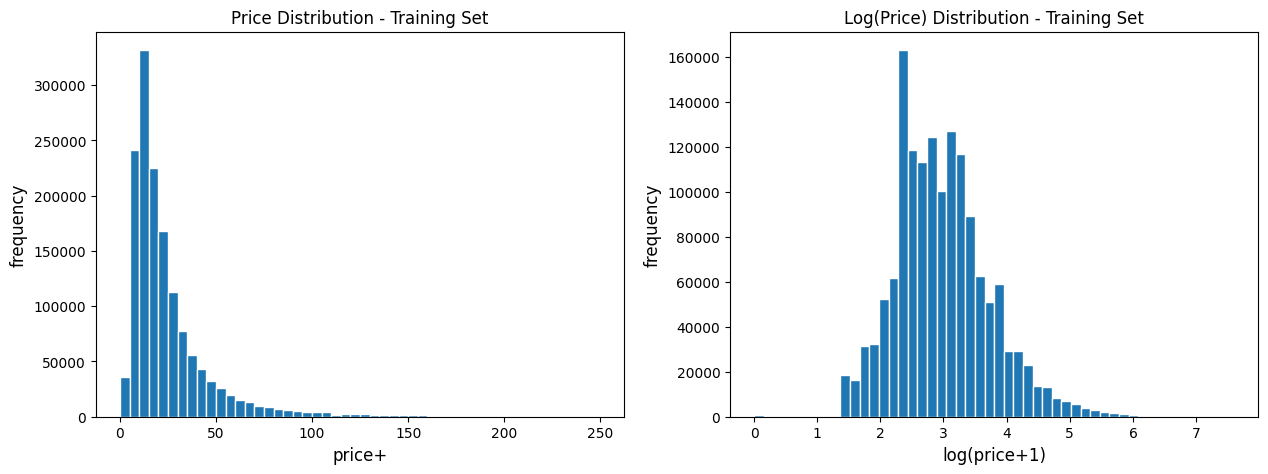

In [ ]:
plt.subplot(1, 2, 1)
(df['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.tick_params(labelsize=10)
plt.title('Price Distribution - Training Set', fontsize=12)

plt.subplot(1, 2, 2)
np.log(df['price']+1).plot.hist(bins=50, figsize=(15,5), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.tick_params(labelsize=10)
plt.title('Log(Price) Distribution - Training Set', fontsize=12)
plt.show()

 The first histogram shows the original distribution of product prices, focusing on values between 0 and 250. This helps identify patterns such as skewness or outliers. The second histogram displays the distribution of the natural logarithm of `price + 1`, which is a common transformation to reduce the impact of outliers and make a skewed distribution closer to a normal distribution.

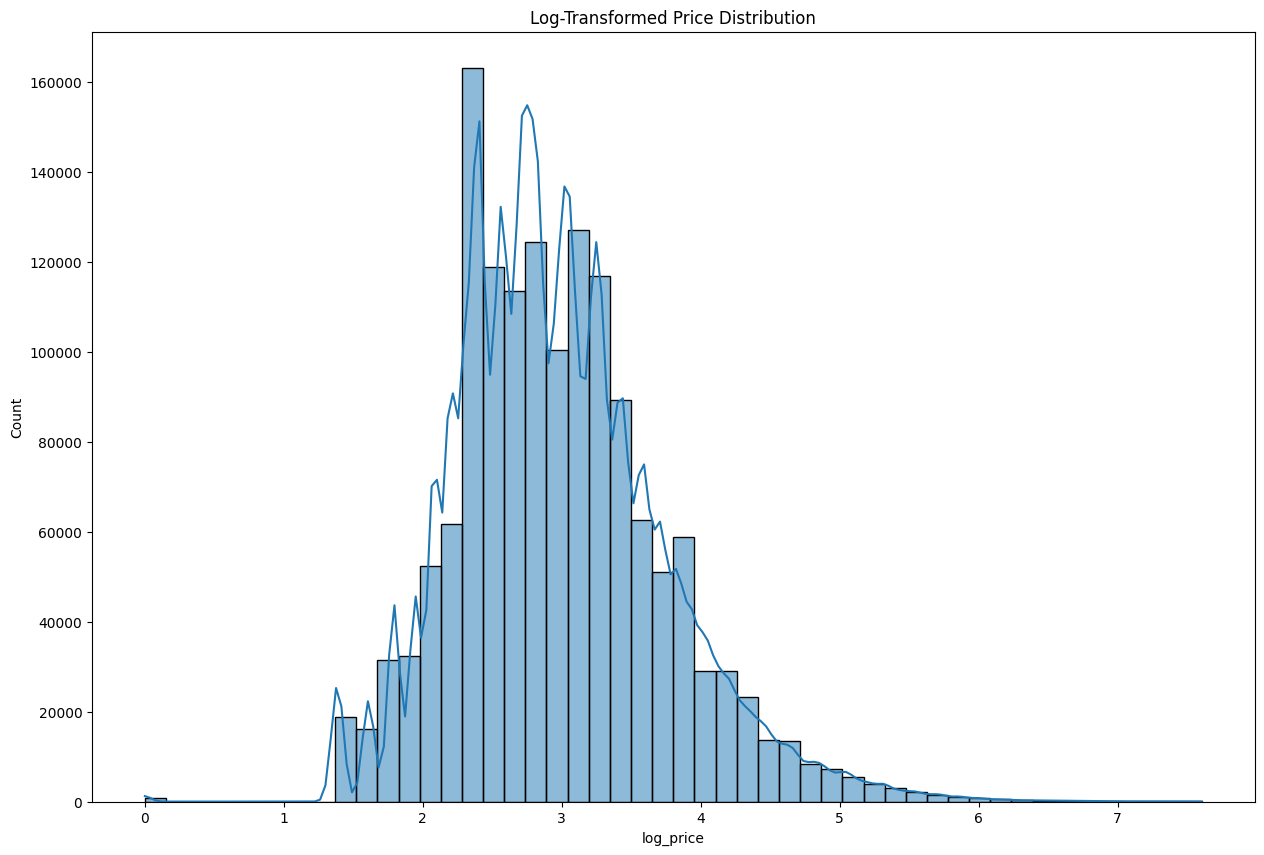

In [ ]:
# lengths distribution
df['log_price'] = np.log1p(df['price'])
plt.figure(figsize=(15, 10))
sns.histplot(df['log_price'], bins=50, kde=True)
plt.title('Log-Transformed Price Distribution')
plt.show()

The graph shows the distribution of prices in the dataset after transforming them using a logarithmic function.
The particularly logarithmic transformation is useful for observing a very concentrated distribution of prices (if the distribution is narrow, centered on a value) or with very high price values ​​that could distort the visibility of the histogram if left on the linear scale.

In [ ]:
df.drop('log_price', axis=1, inplace=True)

## Shipping and Condition

In [ ]:
df.item_condition_id.value_counts()/len(df)

item_condition_id
1    0.432063
3    0.291501
2    0.253268
4    0.021559
5    0.001608
Name: count, dtype: float64

In [ ]:
item_condition_percentages = (df['item_condition_id'].value_counts() / len(df)) * 100
condition_df = item_condition_percentages.reset_index()
condition_df.columns = ['Item Condition ID', 'Percentage']
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(5, 4))
sns.barplot(data=condition_df, x='Item Condition ID', y='Percentage', hue='Item Condition ID', palette="pastel", edgecolor="black", legend=False)

plt.title('Percentage of Items by Condition', fontsize=12)
plt.xlabel('Item Condition ID', fontsize=10)
plt.ylabel('Percentage (%)', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


The dataset shows that the majority of items are in **good or very good condition**, with a relatively small percentage of items in poor or very damaged condition.

In [ ]:
df.shipping.value_counts()/len(df)

shipping
0    0.552726
1    0.447274
Name: count, dtype: float64

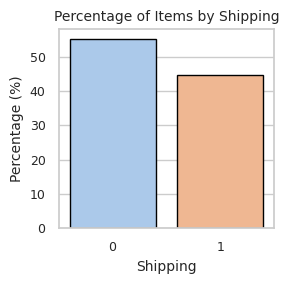

In [ ]:
item_condition_percentages = (df['shipping'].value_counts() / len(df)) * 100
condition_df = item_condition_percentages.reset_index()
condition_df.columns = ['Shipping', 'Percentage']
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(3, 3))
sns.barplot(data=condition_df, x='Shipping', y='Percentage', palette="pastel", edgecolor="black", hue='Shipping', legend = False)

plt.title('Percentage of Items by Shipping', fontsize=10)
plt.xlabel('Shipping', fontsize=10)
plt.ylabel('Percentage (%)', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

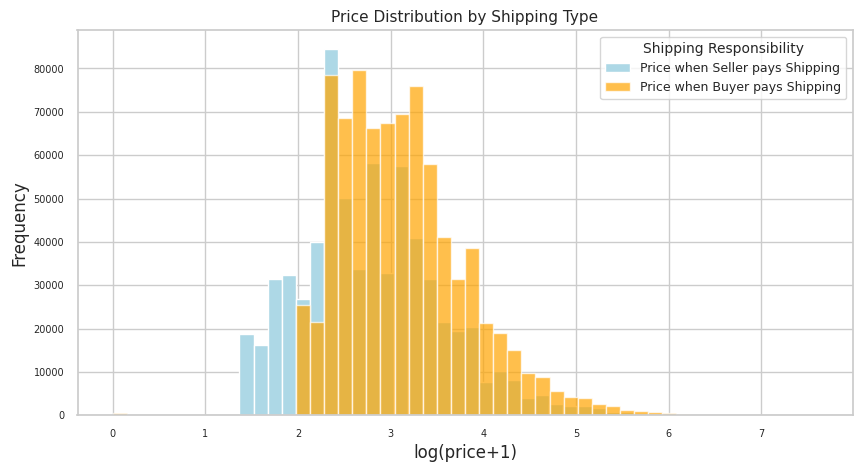

In [ ]:
prc_shipBySeller = df.loc[df.shipping==1, 'price']
prc_shipByBuyer = df.loc[df.shipping==0, 'price']

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(np.log(prc_shipBySeller + 1), color='lightblue', alpha=1.0, bins=50,
        label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer + 1), color='orange', alpha=0.7, bins=50,
        label='Price when Buyer pays Shipping')
ax.set(title='Price Distribution by Shipping Type', xlabel='log(price+1)', ylabel='Frequency')
plt.title('Price Distribution by Shipping Type', fontsize=11)
ax.legend(title='Shipping Responsibility', fontsize=9, title_fontsize=10)
plt.tick_params(labelsize=7)
plt.show()

## Category Name

The *category_name* column is structured hierarchically (e.g. Men/Tops/T-shirts). This provides a great opportunity to extract main categories, subcategories and other information.

In [ ]:
unique_categories = df['category_name'].nunique()
print(f"There are {unique_categories} unique categories in the training set")

There are 1287 unique categories in the training set


There are approximately 1.287 unique categories, but within each of them, we will always see a main/general category first, followed by two more specific subcategories (e.g. Beauty/Makeup/Face or Lips). Additionally, there are approximately 6.327 items that do not have category labels.

First we add the category '*other*' to the instances that have the field corresponding to this feature null:

In [ ]:
df['category_name'].fillna('Other/Other/Other', inplace=True)

In [ ]:
# top 5 categories
df['category_name'].value_counts()[:5]

category_name
Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: count, dtype: int64

In [ ]:
category_split = df['category_name'].str.split('/', expand=True)
category_split_depth = category_split.apply(lambda x: x.notna().sum(), axis=1)
print(f"Maximum category depth: {category_split_depth.max()}")

Maximum category depth: 5


In [ ]:
category_split.head()

0                    1                   2     3     4
0          Men                 Tops            T-shirts  None  None
1  Electronics  Computers & Tablets  Components & Parts  None  None
2        Women       Tops & Blouses              Blouse  None  None
3         Home           Home Décor  Home Décor Accents  None  None
4        Women              Jewelry           Necklaces  None  None

In [ ]:
category_split.isnull().sum()

0          0
1          0
2          0
3    1478146
4    1479476
dtype: int64

Most of the categories extend up to depth 3, but we observed that there are some instances in the dataset that reach depth 5. Since these instances are very rare, we decided to consider only depth 3, adding three new columns in the dataset, named 'main_cat', 'subcat_1' and 'subcat_2'.

We only keep three categories:

In [ ]:
def split_cat(text):
    try:
      return text.split("/")
    except:
      return ("No Label", "No Label", "No Label")

In [ ]:
df['main_cat'], df['subcat_1'], df['subcat_2'] = \
zip(*df['category_name'].apply(lambda x: split_cat(x)))
df.head()

train_id                                 name  item_condition_id   
0         0  MLB Cincinnati Reds T Shirt Size XL                  3  \
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price   
0                                  Men/Tops/T-shirts        NaN   10.0  \
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description     main_cat   
0         1                                 No description yet          Men  \
1         0  This keyboard is in great condition and works ...  Electronics   
2         1  Adorable top with a hint of lace and a key hol...        Women   
3         1  New with tags. Leather horses. Retail for [rm]...         Home   
4         0          Complete with certificate of authenticity        Women   

              subcat_1            subcat_2  
0                 Tops            T-shirts  
1  Computers & Tablets  Components & Parts  
2       Tops & Blouses              Blouse  
3           Home Décor  Home Décor Accents  
4              Jewelry           Necklaces

In [ ]:
df.main_cat.value_counts()/len(df)

main_cat
Women                     0.448141
Beauty                    0.140184
Kids                      0.115808
Electronics               0.082757
Men                       0.063189
Home                      0.045780
Other                     0.034858
Vintage & Collectibles    0.031385
Handmade                  0.020804
Sports & Outdoors         0.017094
Name: count, dtype: float64

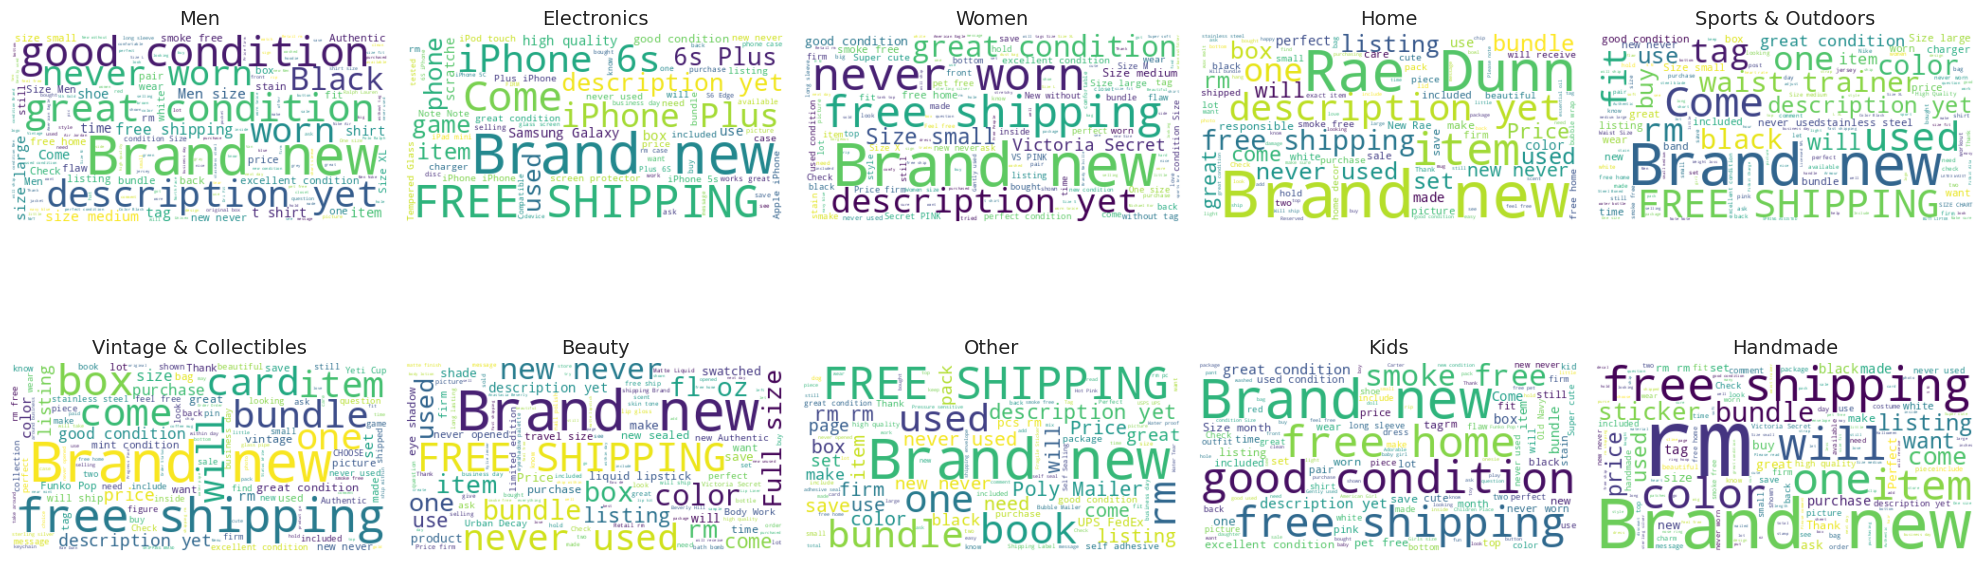

In [ ]:
df['item_description'] = df['item_description'].fillna('').astype(str)

# Prepara le word cloud per le 10 categorie principali
main_categories = df['main_cat'].unique()
num_categories = len(main_categories)

# Configurazione della griglia: 2 righe e 5 colonne
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, category in enumerate(main_categories):
    text = " ".join(df[df['main_cat'] == category]['item_description'])

    # Genera la word cloud
    wordcloud = WordCloud(
        width=400,  # Dimensioni più piccole
        height=200,
        background_color='white',
        colormap='viridis'
    ).generate(text)

    # Disegna la word cloud nell'asse corretto
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(category, fontsize=14)

# Rimuovi assi inutilizzati (se ci sono meno di 10 categorie)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


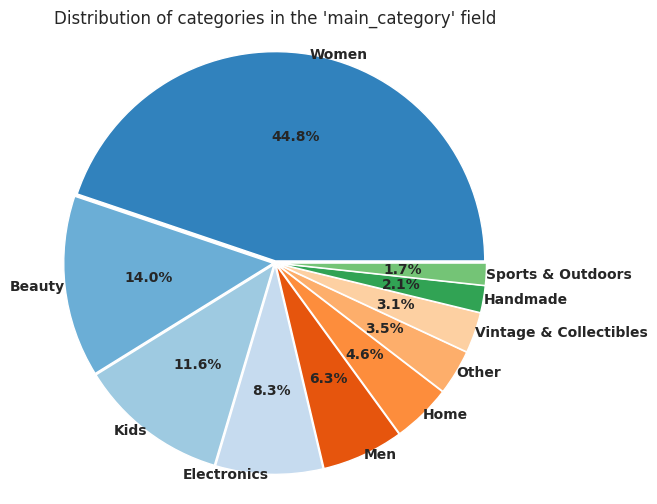

In [ ]:
# main cathegory
labels = df['main_cat'].value_counts().keys()
sizes = df['main_cat'].value_counts()

# creating a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=0,
    colors=plt.cm.tab20c.colors,
    explode=[0.01] * len(labels),
    labeldistance=1,
    textprops={'fontsize': 10, 'weight': 'bold'}
)
plt.title("Distribution of categories in the 'main_category' field")
plt.axis('equal')
plt.show()

In [ ]:
unique_categories = df['subcat_1'].nunique()
print(f"There are {unique_categories} unique first sub-categories in the training set")

There are 113 unique first sub-categories in the training set


In [ ]:
unique_categories = df['subcat_2'].nunique()
print(f"There are {unique_categories} unique second sub-categories in the training set")

There are 870 unique second sub-categories in the training set


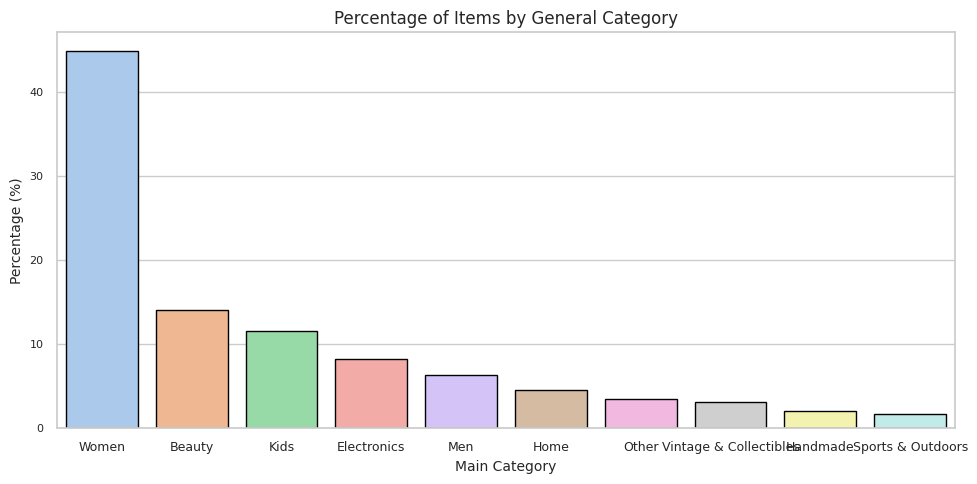

In [ ]:
category_percentages = (df['main_cat'].value_counts() / len(df)) * 100
category_df = category_percentages.reset_index()
category_df.columns = ['Category', 'Percentage']
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 5))
sns.barplot(data=category_df, x='Category', y='Percentage', palette="pastel", edgecolor="black", hue='Category')

plt.title('Percentage of Items by General Category', fontsize=12)
plt.xlabel('Main Category', fontsize=10)
plt.ylabel('Percentage (%)', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


The most represented categories certainly reflect a strong interest in the women's fashion and beauty sector, while categories such as electronics and sports are relatively less widespread.

Overall, the data suggests that the market is very oriented towards clothing and cosmetics, with good involvement also in the categories aimed at children and technology items.

Now let's create a static box plot showing the distribution of prices by main category, using the logarithm to reduce the influence of extreme values.

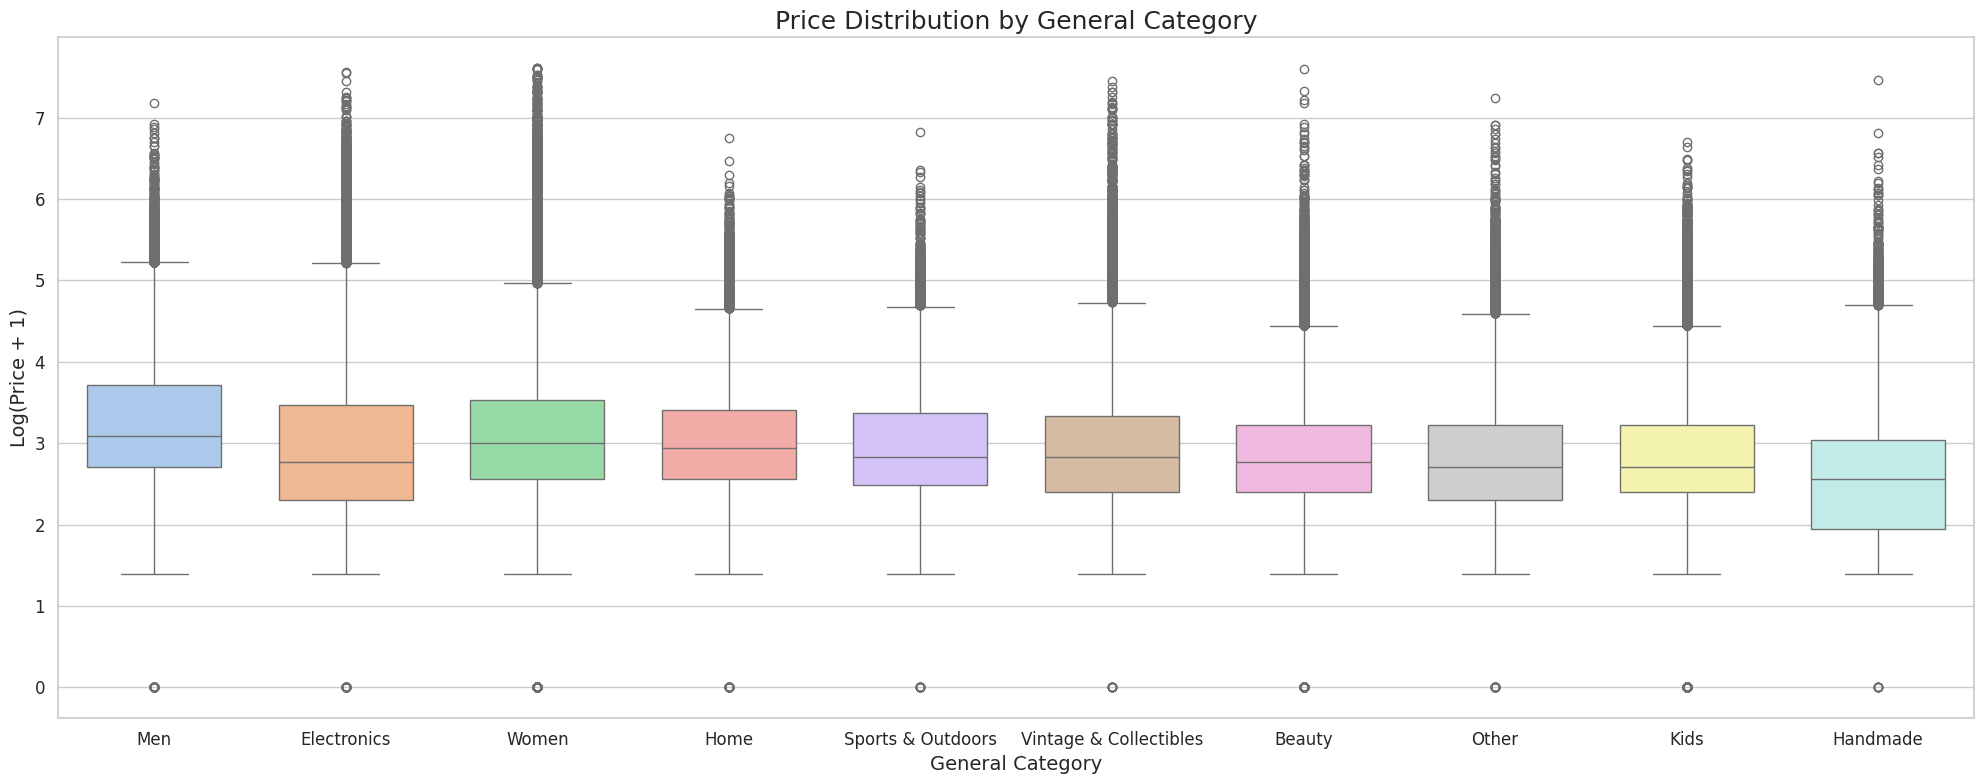

In [ ]:
sns.set(style="whitegrid", palette="pastel")
df['log_price'] = np.log(df['price'] + 1)
plt.figure(figsize=(20, 8))
sns.boxplot(x='main_cat', y='log_price', data=df, palette="pastel", width=0.7, hue='main_cat')

plt.title('Price Distribution by General Category', fontsize=18)
plt.xlabel('General Category', fontsize=14)
plt.ylabel('Log(Price + 1)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

**Distribution Disparity:**

* Some categories, such as "Men" and "Electronics," show a broader distribution, with a long tail toward higher prices (outliers).
* Other categories, such as "Beauty" and "Handmade," show a more concentrated distribution.

**Medians:**

* The median (horizontal line inside the box) varies significantly across categories. For example, the median for "Men" appears to be higher than that for "Beauty."

**Presence of Outliers:**
* All categories show numerous outliers (points outside the whiskers of the boxplot), indicating that some observations are significantly different from the rest of the data.

**Internal Variance:**
* Categories such as "Electronics" and "Men" have larger boxes, indicating greater variance in prices than categories such as "Beauty" or "Kids."

In [ ]:
df['subcat_1'].value_counts()

subcat_1
Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: count, Length: 113, dtype: int64

In [ ]:
df['subcat_2'].value_counts()

subcat_2
Pants, Tights, Leggings    60177
Other                      56551
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
St Patricks                    1
Garbage Disposals              1
Decorating                     1
Pet Food                       1
Ephemera                       1
Name: count, Length: 870, dtype: int64

In [ ]:
# we get the top 15 most frequent subgroups
df['subcat_1'].value_counts().index.values.astype('str')[:15]

array(['Athletic Apparel', 'Makeup', 'Tops & Blouses', 'Shoes', 'Jewelry',
       'Toys', 'Cell Phones & Accessories', "Women's Handbags", 'Dresses',
       "Women's Accessories", 'Jeans', 'Video Games & Consoles',
       'Sweaters', 'Underwear', 'Skin Care'], dtype='<U25')

Text(0, 0.5, 'Number of instances')

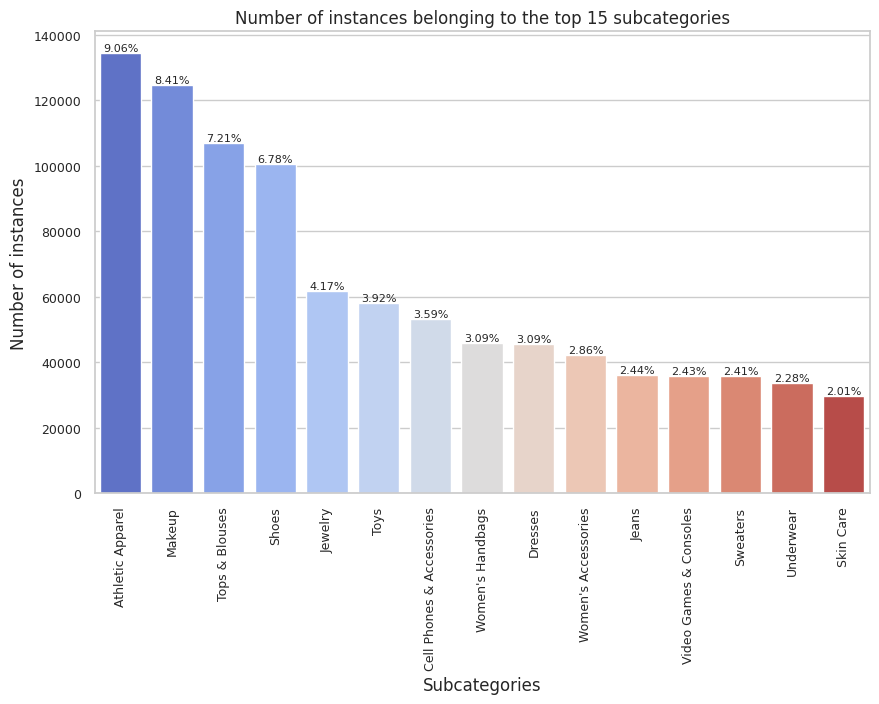

In [ ]:
# date
x = df['subcat_1'].value_counts().index.values.astype('str')[:15]
y = df['subcat_1'].value_counts().values[:15]
pct = [("%.2f" % (v * 100)) + "%" for v in (y / len(df))][:15]

# let's create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=y, palette='coolwarm', hue=x)
for i in range(len(x)):
    plt.text(i, y[i] + 0.5, pct[i], ha='center', va='bottom', fontsize = 8)

# Ridurre la dimensione del testo degli tick
plt.xticks(fontsize=9, rotation=90)  # Rotazione e dimensione delle etichette sull'asse x
plt.yticks(fontsize=9)

# labels and title
plt.title('Number of instances belonging to the top 15 subcategories')
plt.xlabel('Subcategories')
plt.ylabel('Number of instances')

In [ ]:
# train.drop('category_name', axis=1, inplace=True) Non sappiamo ancora come gestirla
df.drop('log_price', axis=1, inplace=True)

In [ ]:
df.head()

train_id                                 name  item_condition_id   
0         0  MLB Cincinnati Reds T Shirt Size XL                  3  \
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price   
0                                  Men/Tops/T-shirts        NaN   10.0  \
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description     main_cat   
0         1                                 No description yet          Men  \
1         0  This keyboard is in great condition and works ...  Electronics   
2         1  Adorable top with a hint of lace and a key hol...        Women   
3         1  New with tags. Leather horses. Retail for [rm]...         Home   
4         0          Complete with certificate of authenticity        Women   

              subcat_1            subcat_2  
0                 Tops            T-shirts  
1  Computers & Tablets  Components & Parts  
2       Tops & Blouses              Blouse  
3           Home Décor  Home Décor Accents  
4              Jewelry           Necklaces

In [ ]:
df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'main_cat', 'subcat_1',
       'subcat_2'],
      dtype='object')

## Brand Name

The *brand_name* column is important for pricing, especially for high-end brands. Let's check the frequency of brands:

In [ ]:
unique_categories = df['brand_name'].nunique()
print(f"There are {unique_categories} unique brand name in the training set")

There are 4809 unique brand name in the training set


In [ ]:
df['brand_name'].value_counts()

brand_name
PINK                    54088
Nike                    54043
Victoria's Secret       48036
LuLaRoe                 31024
Apple                   17322
                        ...  
The Learning Journey        1
Pampers Baby Fresh          1
Huggies One & Done          1
Classic Media               1
Kids Only                   1
Name: count, Length: 4809, dtype: int64

In [ ]:
# let's identify the percentage of missing values ​​in brand_name:
df['brand_name'].isnull().mean() * 100

42.675687251902986

The high percentage of missing values ​​(42.7%) suggests creating a label for the "unknown brand".

In [ ]:
# let's create a special category for "unknown"
df['brand_name'].fillna('Unknown', inplace=True)

In [ ]:
df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
main_cat             0
subcat_1             0
subcat_2             0
dtype: int64

## Item Description

The *item_description* column contains descriptive text that is likely to be a strong predictor.

Let's start by calculating the average length of descriptions.

In [ ]:
# we fill the missing values ​​with a generic string
df['item_description'].fillna('No description available', inplace=True)

In [ ]:
df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
main_cat             0
subcat_1             0
subcat_2             0
dtype: int64

In [ ]:
df['description_length'] = df['item_description'].str.len()
df['description_length'].describe()

count    1.482535e+06
mean     1.457114e+02
std      1.744464e+02
min      0.000000e+00
25%      4.000000e+01
50%      8.600000e+01
75%      1.740000e+02
max      1.046000e+03
Name: description_length, dtype: float64

In [ ]:
# longer description
df['description_length'].max()

1046

**Average length** is about **145 characters**, with a maximum of 1046.

There is a high variability in the descriptions, suggesting that the text may contain valuable information.

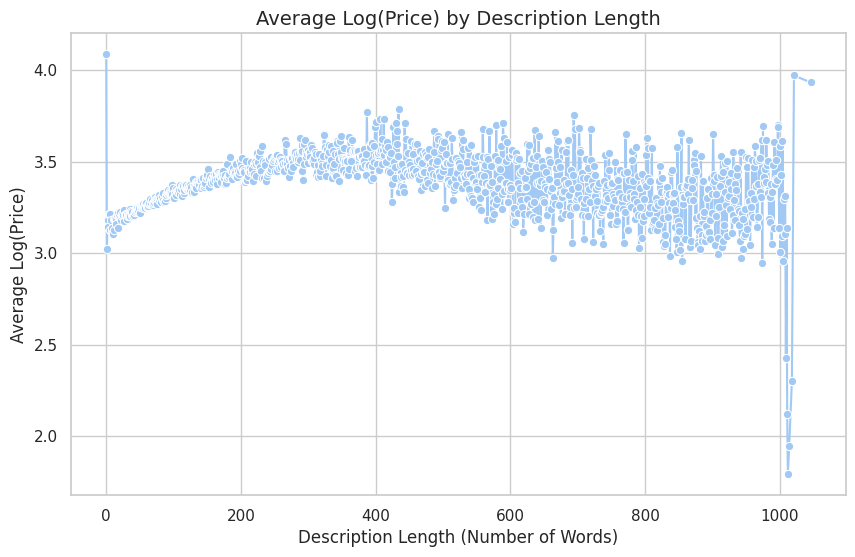

In [ ]:
# We group by description length and calculate the average price for each length
f = df.groupby('description_length')['price'].mean().reset_index()

# We use f to calculate the logarithm of average prices.
f['log_price'] = np.log(f['price'] + 1)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=f, x='description_length', y='log_price', marker='o')
plt.title('Average Log(Price) by Description Length', fontsize=14)
plt.xlabel('Description Length (Number of Words)', fontsize=12)
plt.ylabel('Average Log(Price)', fontsize=12)
plt.grid(True)
plt.show()


From the graph the length of the description seems to be relevant, so for now we keep the relative column and later we will verify with a statistical test if there is a correlation between the length of the text and the price of the product

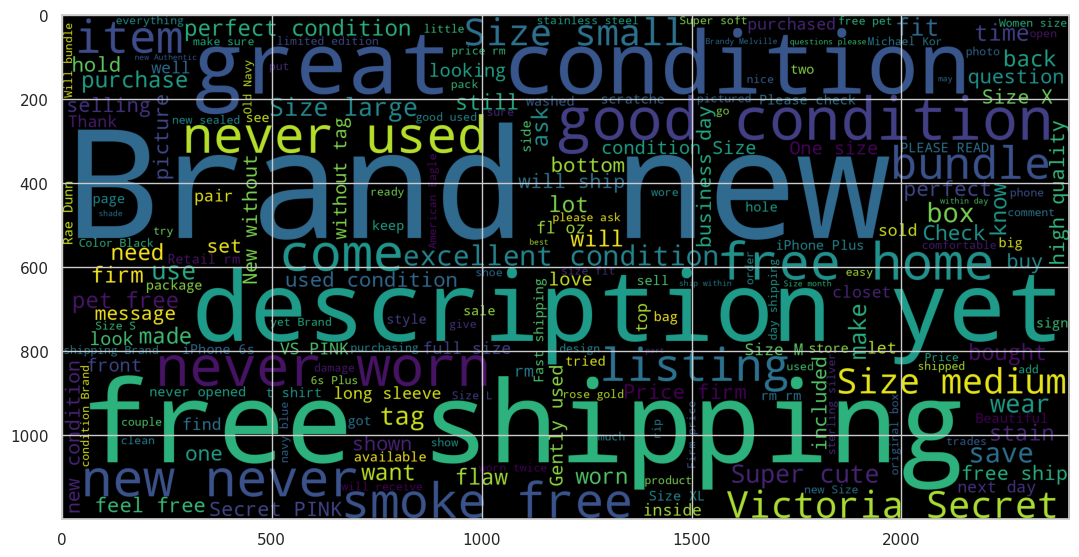

In [ ]:
#python -m pip install wordcloud
from wordcloud import WordCloud
import os
wordcloud = WordCloud(width = 2400, height = 1200).generate(" ".join(df.item_description.astype(str)))
plt.figure(figsize = (13, 10))
plt.imshow(wordcloud)
plt.show()

WORD CLOUD PER CATEGORIA!!!

# Feature Utility Analysis and Correlation with the Target

**Analyzing feature** usefulness is important to:

* Identify which variables are most relevant to the target.
* Remove unuseful or redundant features to improve efficiency and reduce overfitting.

## Numeric Features


In [ ]:
df.head()

train_id                                 name  item_condition_id   
0         0  MLB Cincinnati Reds T Shirt Size XL                  3  \
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price   
0                                  Men/Tops/T-shirts    Unknown   10.0  \
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents    Unknown   35.0   
4                            Women/Jewelry/Necklaces    Unknown   44.0   

   shipping                                   item_description     main_cat   
0         1                                 No description yet          Men  \
1         0  This keyboard is in great condition and works ...  Electronics   
2         1  Adorable top with a hint of lace and a key hol...        Women   
3         1  New with tags. Leather horses. Retail for [rm]...         Home   
4         0          Complete with certificate of authenticity        Women   

              subcat_1            subcat_2  description_length  
0                 Tops            T-shirts                  18  
1  Computers & Tablets  Components & Parts                 188  
2       Tops & Blouses              Blouse                 124  
3           Home Décor  Home Décor Accents                 173  
4              Jewelry           Necklaces                  41

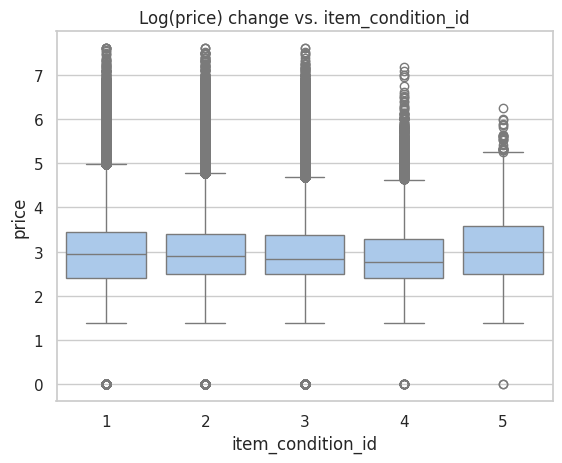

In [ ]:
# Boxplot to observe the price variation with respect to item_condition_id
sns.boxplot(x='item_condition_id', y=np.log1p(df['price']), data=df)
plt.title('Log(price) change vs. item_condition_id')
plt.show()

Notes:
* Each value of item_condition_id (1-5) appears to be associated with a slight variation in log prices. However, the price means (line inside the box) do not vary dramatically between groups.
* Values ​​of item_condition_id = 5 show a slight trend toward lower prices, suggesting that items in worse condition tend to cost less.
* Items with item_condition_id = 1 (the best condition) appear to have a slightly higher distribution of average price than worse conditions.
* The effect of item condition (item_condition_id) on price is visible but **not very strong**. It may still be useful to include this feature in your model, especially in combination with other features (e.g. *brand_name* or *category_name*).
* It may also be useful to test a categorical transformation to a dummy variable to represent item_condition_id, if your model requires numeric inputs.

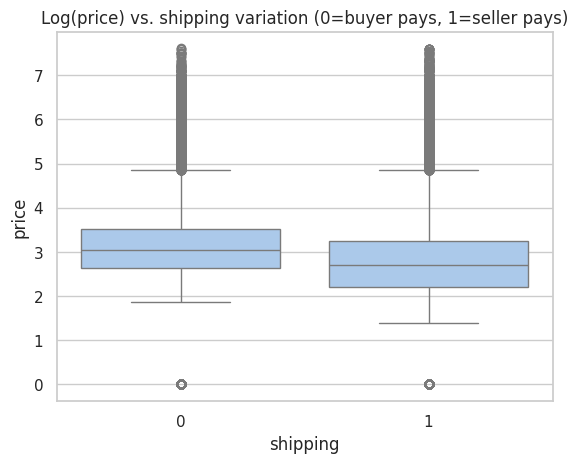

In [ ]:
# Boxplot to observe log(price) vs. shipping cost
sns.boxplot(x='shipping', y=np.log1p(df['price']), data=df)
plt.title('Log(price) vs. shipping variation (0=buyer pays, 1=seller pays)')
plt.show()

* Although the difference in median price for the two groups is **modest**, this feature could still be useful in the model in combination with other variables to capture non-linear interactions or combined effects.
* It could be more significant for some product categories (e.g. low-cost items where shipping costs are more important).

### Statistical tests

To further analyze the relationship between the variables and the target (price), two statistical tests were used: ANOVA, T-test and the Pearson Coefficient.

* **ANOVA (Analysis of Variance)** was used to compare the means of multiple groups. In this case, we used ANOVA to test whether the different conditions of the item (item_condition_id) significantly affect the price. This test is especially useful when we want to compare more than two groups.

* **T-test** was used to compare two groups, as in the case of the Boolean variable shipping (0 = buyer pays, 1 = seller pays). The T-test tests whether the difference between the means of two groups is statistically significant.

* **Pearson Coefficient**: used to test for a linear correlation between the length of descriptions and price.

In [ ]:
# ANOVA for item_condition_id
groups = [df[df['item_condition_id'] == i]['price'] for i in range(1, 6)]
anova_result = f_oneway(*groups)
print("ANOVA p-value for item_condition_id:", anova_result.pvalue)

ANOVA p-value for item_condition_id: 2.8499431199608725e-79


In [ ]:
# T-test for shipping
ttest_result = ttest_ind(df[df['shipping'] == 0]['price'],
                         df[df['shipping'] == 1]['price'])
print("T-test p-value for shipping:", ttest_result.pvalue)

T-test p-value for shipping: 0.0


In [ ]:
# logarithmic transformation of price
df['log_price'] = np.log1p(df['price'])

# calculating Pearson Correlationn
corr, p_value = pearsonr(df['description_length'], df['log_price'])

print(f"Pearson correlation: {corr}")
print(f"P-value: {p_value}")

# interpretation
if p_value < 0.05:
    print("The correlation between desc_len and log_price is statistically significant.")
else:
    print("No statistically significant correlation was found.")

Pearson correlation: 0.03019862484129018
P-value: 4.1471642064667117e-296
The correlation between desc_len and log_price is statistically significant.


Comment on the results:
* **ANOVA p-value** for item_condition_id: 2.8499431199608725e-79 The p-value obtained is extremely low (more than 10 orders of magnitude less than 0.05), which suggests that there are significant differences in price based on the condition of the item. Therefore, we can conclude that the item_condition_id variable significantly affects the price, with strong statistical evidence against the null hypothesis (which stated that there were no differences between the conditions).

* **T-test p-value** for shipping: 0.0 The p-value for the T-test is also 0, which indicates that there is a statistically significant difference in price between items for which the buyer or seller pays shipping costs. This suggests that the shipping variable has a significant impact on the price, and items with different shipping conditions have a different average price.

* The **Pearson correlation coefficient value** between desc_len and log_price is 0.03, which indicates a very weak and positive correlation between description length and price (in logarithmic scale). The large volume of data leads to a very low p-value, which makes the correlation significant.
From a practical point of view, the impact of desc_len on price appears almost irrelevant. The variable may not be particularly useful on its own, but it may become more useful when combined with other features (e.g. interactions with product categories).

In every tests, the results show that **every variables** (item_condition_id, desc_len and shipping) **are significant factors in determining the price of the items**.

## Categorical Features

The features *category_name* and *brand_name* are categorical. We can study their distribution relative to the target.

These features have many unique categories, so we cannot easily analyze them one by one.

Strategies:
* Analyze the top categories relative to the average price.
* Calculate the mean/median of prices for each category and observe the variation.

category_name
Vintage & Collectibles/Antique/Furniture                  195.000000
Handmade/Bags and Purses/Clutch                           180.222222
Electronics/Computers & Tablets/Laptops & Netbooks        177.089176
Kids/Strollers/Standard                                   163.666667
Electronics/Computers & Tablets/Desktops & All-In-Ones    149.329412
Vintage & Collectibles/Bags and Purses/Handbag            139.562546
Kids/Strollers/Travel Systems                             124.600000
Home/Home Appliances/Air Conditioners                     121.142857
Kids/Strollers/Lightweight                                117.111111
Electronics/Cameras & Photography/Digital Cameras         112.305349
Name: price, dtype: float64


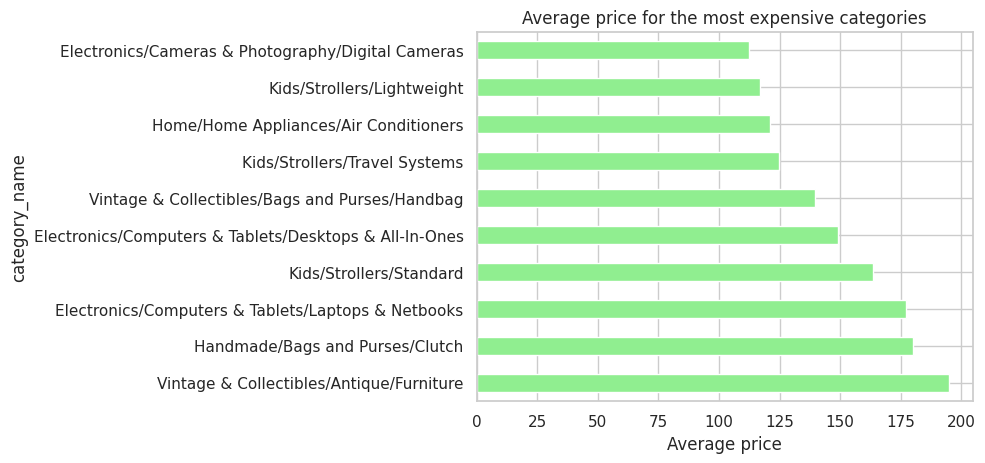

In [ ]:
# top categories and their average price
category_avg_price = df.groupby('category_name')['price'].mean().sort_values(ascending=False).head(10)
print(category_avg_price)

# visualization
category_avg_price.plot(kind='barh', title='Average price for the most expensive categories', color='lightgreen')
plt.xlabel('Average price')
plt.show()

brand_name
Demdaco             429.000000
Proenza Schouler    413.250000
Auto Meter          344.000000
Oris                300.000000
MCM Worldwide       289.173913
Longines            254.000000
Vitamix             253.111111
Blendtec            251.800000
David Yurman        248.611570
Celine              238.780822
Name: price, dtype: float64


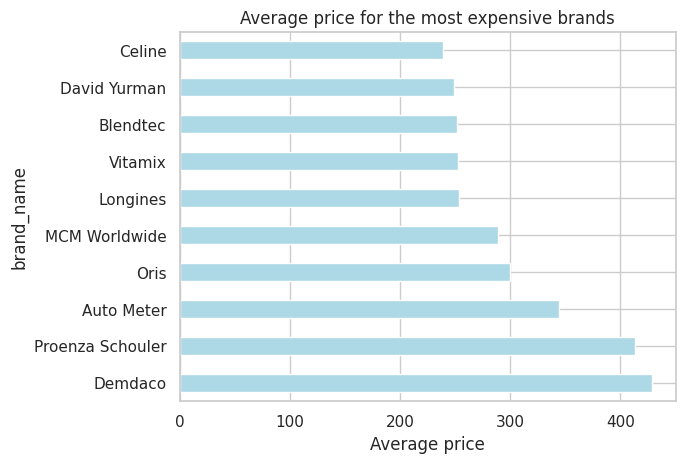

In [ ]:
# top brand and their average price
brand_avg_price = df.groupby('brand_name')['price'].mean().sort_values(ascending=False).head(10)
print(brand_avg_price)

# visualization
brand_avg_price.plot(kind='barh', title='Average price for the most expensive brands', color='lightblue')
plt.xlabel('Average price')
plt.show()

### Findings Analysis


* **Average Price by Brand**: brands with the highest average prices include luxury brands such as Demdaco, Proenza Schouler, and MCM Worldwide, with prices above $400. These brands are associated with high-end products, primarily in the luxury fashion and accessories sector.

* **Average Price by Category**: the most expensive categories include Vintage & Collectibles and Handmade, with subcategories such as antique furniture and artisanal handbags also commanding high prices. Electronics categories such as Laptops and Desktops also show high average prices, as do baby products such as strollers and air conditioners.

**Conclusion**: luxury and collectible categories and brands tend to have higher prices. This information can be useful for making more accurate price predictions in the model.

# Item Name and Description Text Processing

**Text preprocessing** is a critical step in preparing data for machine learning models, especially when working with unstructured data such as text descriptions. This step aims to reduce noise in texts and transform them into a standardized format that is more suitable for analysis and modeling.

Typical operations include **data cleansing** (e.g., removing special characters and stopwords), **normalization** (using techniques such as lowercasing and lemmatization), and finally **tokenization** to convert sentences into parsable units.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/MindHard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/MindHard/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')

# stopwords
stop = set(stopwords.words("english"))

def tokenize(text):
    """
    Tokenize text by:
    1. Segmenting it into sentences using sent_tokenize.
    2. Breaking sentences into words using word_tokenize.
    3. Removing punctuation, numbers, and stop words.
    4. Keeping only alphabetic words of length >= 3, converted to lowercase.
    5. Lemmatizing the words to their base form.
    """
    try:
        regex = re.compile(f"[{re.escape(string.punctuation)}0-9\\r\\t\\n]")
        cleaned_text = regex.sub(" ", text)  # Remove punctuation, numbers and special characters
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(cleaned_text)]
        tokens = [token for sublist in tokens_ for token in sublist]

        # We filter alphabetic words, non-stopwords, length >= 3, in lowercase
        tokens = [token.lower() for token in tokens if token.lower() not in stop and re.search('[a-zA-Z]', token)]

        # Lemmatization
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if len(token) >= 3]

        return " ".join(lemmatized_tokens)


    except TypeError as e:
        print(f"Error processing text: {text}. Exception: {e}")
        return []

[nltk_data] Downloading package wordnet to /home/MindHard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['item_description'][2]

'Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!'

In [ ]:
ris = tokenize(df['item_description'][2])
print(ris)

adorable top hint lace key hole back pale pink also available white


In [ ]:
df['item_description'] = df['item_description'].map(tokenize)
df['name'] = df['name'].map(tokenize)

In [ ]:
# we saved df on drive
df.to_csv('df_preprocessed.csv', index=False)

# Feature Encoding & Feature Vectorization


**Feature Encoding** and **Feature Vectorization** are crucial techniques for transforming categorical and textual variables into a numerical representation that can be understood by machine learning models. Mathematical models, in fact, cannot work directly with non-numeric data, such as words in texts or categories.

First, however, it is essential to **split the dataset into train, validation and test** to avoid the risk of overfitting and to ensure that the model is tested on data it has never seen during training.

In [ ]:
anna_path = '/content/drive/MyDrive/Magistrale/2°anno/Advanced ML/Advanced Machine Learning/df_preprocessed.csv'
fra_path = 'df_preprocessed.csv'
#fra_path = '/content/drive/MyDrive/Advanced Machine Learning/df_preprocessed.csv'
max_path = ''

if os.path.exists(anna_path):
    df = pd.read_csv(anna_path)
elif os.path.exists(fra_path):
    df = pd.read_csv(fra_path)
elif os.path.exists(max_path):
    df = pd.read_csv(max_path)
else:
    print("File not found")

In [ ]:
# we verified that there are no missing values in the feature item_description
if df['item_description'].isnull().any() or (df['item_description'] == ' ').any():
    print("There are missing values in the feature 'item_description'")
else:
    print("There are no missing values in the feature 'item_description'")

There are missing values in the feature 'item_description'


In [ ]:
# we verified that there are no missing values in the feature name
if df['name'].isnull().any() or (df['name'] == ' ').any():
    print("There are missing values in the feature 'name'")
else:
    print("There are no missing values in the feature 'name'")

There are missing values in the feature 'name'


In [ ]:
print(df['name'].isnull().sum())
print(df['item_description'].isnull().sum())

1208
3555


In [ ]:
print((df['name']== ' ').sum())
print((df['item_description']== ' ').sum())

0
0


In [ ]:
# we fill the missing values with a generic string
df['name'].fillna('missing name', inplace=True)
df['item_description'].fillna('missing description', inplace=True)

In [ ]:
print(df['name'].isnull().sum())
print(df['item_description'].isnull().sum())

0
0


We chose to apply the **logarithmic transformation** to the 'price' column for several reasons related to the data distribution and statistical properties.
Prices can be skewed (with very large values ​​affecting the mean), so applying the logarithm helps to "stabilize" the variance and make the distribution more symmetric. Additionally, the logarithm reduces the influence of outliers and allows the model to learn more effectively from a wider range of price values. For these reasons, we replaced the 'price' column with 'log_price' in subsequent analyses and visualizations.


In [ ]:
y = df["log_price"]
X = df.drop(columns=['price', 'log_price', 'train_id'])

# division of the dataset (80% training, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train.shape, X_validation.shape, X_test.shape

((1186028, 10), (148253, 10), (148254, 10))

In [ ]:
X_train.head()

name  item_condition_id   
1416089                       lularoe kid legging                  3  \
1423955                  bundle display mannequin                  1   
403867   living proof perfect hair day dry shampo                  1   
701974                               palazzo pant                  2   
1124330         reserved jas pink boyshorts large                  1   

                             category_name brand_name  shipping   
1416089             Kids/Boys (4+)/Bottoms    Unknown         1  \
1423955                  Other/Other/Other    Unknown         0   
403867   Beauty/Hair Care/Styling Products    Unknown         0   
701974            Women/Pants/Casual Pants    Unknown         0   
1124330            Women/Underwear/Panties       PINK         1   

                                          item_description main_cat   
1416089                         worn still great condition     Kids  \
1423955                                          brand new    Other   
403867   listing full size bottle living proof perfect ...   Beauty   
701974   like new adorable black white palazzo pant siz...    Women   
1124330      new tag morning sky sheer seafoam olive green    Women   

          subcat_1          subcat_2  description_length  
1416089  Boys (4+)           Bottoms                  35  
1423955      Other             Other                   9  
403867   Hair Care  Styling Products                 463  
701974       Pants      Casual Pants                 589  
1124330  Underwear           Panties                  51

## Vectorization (textual feature)

For vectorization, we adopted two different approaches based on the type of model to be used:
* For models that favor sparse matrices (such as Ridge Regression), we chose **TfidfVectorizer** for the *item_description* column and **CountVectorizer** for the *name* column.
* For models that require compressed matrices (such as neural networks implemented with Keras), we opted to use **Word2Vec**.

### Count Vectorizer and TdifVectorizer

For text preprocessing, we decided to use two different vectorization techniques for the product name and description.

* The **CountVectorizer** was used for the product name, since this field tends to be short and contains key information such as product type and brand. This technique effectively captures the frequency of the main words in the name.

* For the description, we chose the **TfidfVectorizer** with a range of n-grams (1,3), since the description is generally longer and more varied. The TF-IDF helps to give weight to the most significant words, reducing the influence of common words, while n-grams allow to capture sequences of words that can improve the representation of the meaning of the text.

This choice allows to optimally treat the distinctive features of each type of text, improving the quality of the information to be used in the machine learning model.

In [ ]:
# let's create the vectorizer with CountVectorizer
cnt_vec = CountVectorizer()

# we vectorize the training set
X_train_cv = cnt_vec.fit_transform(X_train['name'])

# we vectorize the validation set
X_validation_cv = cnt_vec.transform(X_validation['name'])

# we vectorize the test set
X_test_cv = cnt_vec.transform(X_test['name'])

In [ ]:
# let's create the vectorizer with tfidf
vectorizer = TfidfVectorizer()

# we vectorize the training set
X_train_tfidf = vectorizer.fit_transform(X_train['item_description'])

# we vectorize the validation set
X_validation_tfidf = vectorizer.transform(X_validation['item_description'])

# we vectorize the test set
X_test_tfidf = vectorizer.transform(X_test['item_description'])

In [ ]:
print('name vectorization shape:', X_train_cv.shape)
print('item_description vectorization shape:',X_train_tfidf.shape)

name vectorization shape: (1186028, 76227)
item_description vectorization shape: (1186028, 109127)


### Word2Vec

**Word2Vec** is an advanced technique for representing words in dense numerical vectors, used in the field of natural language processing (NLP). Developed by Google, this model transforms words into vectors starting from their context, capturing semantic and syntactic relationships between them.

Unlike approaches such as Bag-of-Words or TF-IDF, Word2Vec produces continuous low-dimensional representations that preserve semantic similarities. There are two main Word2Vec architectures:

* **Continuous Bag-of-Words (CBOW)**: predicts a word based on the surrounding context.
* **Skip-Gram**: predicts the surrounding context starting from a single word.

In [ ]:
# concatenation of 'item_description' and 'name' features
def preprocess_sentences(df, text_columns):
    return df[text_columns].fillna('').apply(lambda x: ' '.join(x), axis=1).apply(str.split).tolist()

# concatenation of 'item_description' and 'name' features
train_sentences = preprocess_sentences(X_train, ['item_description', 'name'])
validation_sentences = preprocess_sentences(X_validation, ['item_description', 'name'])
test_sentences = preprocess_sentences(X_test, ['item_description', 'name'])

# we configure Word2Vec template
w2v_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# function to calculate the mean vector of a sentence
def sentence_to_vector(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# we create mean vectors for each sentence in the dataset
X_train_w2v = np.array([sentence_to_vector(sentence, w2v_model) for sentence in train_sentences])
X_validation_w2v = np.array([sentence_to_vector(sentence, w2v_model) for sentence in validation_sentences])
X_test_w2v = np.array([sentence_to_vector(sentence, w2v_model) for sentence in test_sentences])

In [ ]:
print('Word2Vec shape:', X_train_w2v.shape)

Word2Vec shape: (1186028, 100)


## Encoding (categorial feature)

For categorical features, we chose two distinct approaches to encode them:
* **One-Hot Encoding**: ideal for creating sparse matrices, this technique represents each category as a binary vector where only one position is set to 1 and all others to 0. This approach is particularly useful for models that can exploit the sparseness of the data, such as those based on regression or some ensemble methods.
* **Label Encoding**: used for compressed representations, this technique assigns each category a unique numerical value. It is suitable for models that work best with scalar numerical inputs, such as neural networks. However, it is important to remember that this representation may introduce an implicit order to the categories that does not exist, so it should be used with caution in models that are sensitive to such a relationship.

### One-Hot Encoder

In this cell, we apply **One-Hot Encoding** to the categorical variables in our dataset. One-Hot Encoding is a common technique in machine learning to represent numerical categorical variables in a format that can be easily understood by models.

In [ ]:
X_train.dtypes

name                  object
item_condition_id      int64
category_name         object
brand_name            object
shipping               int64
item_description      object
main_cat              object
subcat_1              object
subcat_2              object
description_length     int64
dtype: object

In [ ]:
# find all unique categories for each column in all sets
brand_categories = np.union1d(X_train['brand_name'].unique(), np.union1d(X_validation['brand_name'].unique(), X_test['brand_name'].unique()))
item_condition_categories = np.union1d(X_train['item_condition_id'].unique(), np.union1d(X_validation['item_condition_id'].unique(), X_test['item_condition_id'].unique()))
shipping_categories = np.union1d(X_train['shipping'].unique(), np.union1d(X_validation['shipping'].unique(), X_test['shipping'].unique()))
category_1_categories = np.union1d(X_train['main_cat'].unique(), np.union1d(X_validation['main_cat'].unique(), X_test['main_cat'].unique()))
category_2_categories = np.union1d(X_train['subcat_1'].unique(), np.union1d(X_validation['subcat_1'].unique(), X_test['subcat_1'].unique()))
category_3_categories = np.union1d(X_train['subcat_2'].unique(), np.union1d(X_validation['subcat_2'].unique(), X_test['subcat_2'].unique()))

# categories in a list of lists (one list per column)
categories_list = [
    brand_categories,
    item_condition_categories,
    shipping_categories,
    category_1_categories,
    category_2_categories,
    category_3_categories
]

# now pass these categories into OneHotEncoder when you perform the fitting
ohe = OneHotEncoder(categories=categories_list, handle_unknown='ignore', sparse=True) # su colab sparse_output = True

# select categorical columns
categorical_features = ['brand_name', 'item_condition_id', 'shipping', 'main_cat', 'subcat_1', 'subcat_2']

# training data - Fit and Transform (only on the training set)
X_train_encoded = ohe.fit_transform(X_train[categorical_features])

# validation data - Transformation using learned encoding
X_validation_encoded = ohe.transform(X_validation[categorical_features])

# test data - Transformation using learned encoding
X_test_encoded = ohe.transform(X_test[categorical_features])

In [ ]:
X_train_encoded = X_train_encoded.astype(np.float32)
X_validation_encoded = X_validation_encoded.astype(np.float32)
X_test_encoded = X_test_encoded.astype(np.float32)

In [ ]:
# now we convert column 'description_length' to sparse matrix format
description_length_train = csr_matrix(X_train['description_length'].values.reshape(-1, 1))
description_length_validation = csr_matrix(X_validation['description_length'].values.reshape(-1, 1))
description_length_test = csr_matrix(X_test['description_length'].values.reshape(-1, 1))

In [ ]:
# we combine training data
X_train_onehot = hstack([X_train_encoded, X_train_tfidf, X_train_cv, description_length_train])

# we combine validation data
X_validation_onehot = hstack([X_validation_encoded, X_validation_tfidf, X_validation_cv, description_length_validation])

# we combine test data
X_test_onehot = hstack([X_test_encoded, X_test_tfidf, X_test_cv, description_length_test])

In [ ]:
X_train_onehot.shape, X_validation_onehot.shape, X_test_onehot.shape

((1186028, 191165), (148253, 191165), (148254, 191165))

In [ ]:
X_train_onehot

<1186028x191165 sparse matrix of type '<class 'numpy.float64'>'
	with 29705341 stored elements in Compressed Sparse Row format>

In [ ]:
# saved sparse matrix
#save_npz('X_train_onehot.npz', X_train_onehot)
#save_npz('X_validation_onehot.npz', X_validation_onehot)
#save_npz('X_test_onehot.npz', X_test_onehot)

### Label Encoder

**Label Encoding** is a technique used to transform categorical values ​​(textual or nominal) into integers. Each unique category is mapped to an integer.

Unlike One-Hot Encoding, Label Encoding represents categorical values ​​with a single column and does not introduce sparseness.

In [ ]:
# list of categorical columns to transform with Label Encoding
from sklearn.preprocessing import MinMaxScaler


categorical_features = ['brand_name', 'category_name', 'main_cat', 'subcat_1', 'subcat_2']

# dictionary to save LabelEncoders for each column
label_encoders = {}

# encoding for the training set
X_train_encoded = X_train.copy()
for col in categorical_features:
    le = LabelEncoder()
    # Fit sul set di training e trasformazione
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    label_encoders[col] = le  # Salva il LabelEncoder per la colonna

# encoding for validation and test set using same LabelEncoders
X_validation_encoded = X_validation.copy()
X_test_encoded = X_test.copy()
for col in categorical_features:
    le = label_encoders[col]
    # Solo trasformazione (senza fit)
    le.classes_ = np.append(le.classes_, '<unknown>')  # Aggiunge una classe di default
    X_validation_encoded[col] = le.transform(X_validation[col].apply(lambda x: x if x in le.classes_ else '<unknown>'))
    le.classes_ = np.append(le.classes_, '<unknown>')  # Aggiunge una classe di default
    X_test_encoded[col] = le.transform(X_test[col].apply(lambda x: x if x in le.classes_ else '<unknown>'))

# non-categorical columns: shipping, item_condition_id, description_length
# we keep them unchanged
numerical_features = ['shipping', 'item_condition_id', 'description_length']
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# merging the coded categorical columns and the numeric ones
X_train_le = X_train_encoded[categorical_features + numerical_features]
X_validation_le = X_validation_encoded[categorical_features + numerical_features]
X_test_le = X_test_encoded[categorical_features + numerical_features]

# final results
#X_train_le.head()

We used **Label Encoding** to convert the categorical columns of the dataset (*category_name*, *brand_name*, *main_cat*, *subcat_1*, *subcat_2*) into integer numeric values. To do so, we applied scikit-learn's LabelEncoder, fitting the training dataset and transforming both training, validation and test according to the learned mapping.

The numeric columns (*shipping*, *item_condition_id*, *description_length*) were kept **unchanged**, as they were ready to be used. Finally, we combined all the features (numeric and transformed) into a final dataset. The textual features are missing and then we are ready to train the Machine Learning model.

In [ ]:
X_train_le

brand_name  category_name  main_cat  subcat_1  subcat_2  shipping   
1416089        4215            542         4        16       105         1  \
1423955        4215            864         6        72       552         0   
403867         4215             22         0        50       735         0   
701974         4215           1175         9        75       170         0   
1124330        3057           1247         9       107       566         1   
...             ...            ...       ...       ...       ...       ...   
259178          671            601         4        45       271         0   
1414414        4215           1236         9       103       458         0   
131932         4215            673         4       105       257         0   
671155          255             78         1        23       136         0   
121958         4215             81         1        23       173         1   

         item_condition_id  description_length  
1416089                  3                  35  
1423955                  1                   9  
403867                   1                 463  
701974                   2                 589  
1124330                  1                  51  
...                    ...                 ...  
259178                   3                  73  
1414414                  1                  83  
131932                   1                  97  
671155                   1                  18  
121958                   1                 578  

[1186028 rows x 8 columns]

In [ ]:
# concatenation of Word2Vec features with encoded categorical features
X_train_combined = np.hstack((X_train_w2v, X_train_le))
X_validation_combined = np.hstack((X_validation_w2v, X_validation_le))
X_test_combined = np.hstack((X_test_w2v, X_test_le))

In [ ]:
# print the shape of the final datasets
X_train_combined.shape, X_validation_combined.shape, X_test_combined.shape

((1186028, 108), (148253, 108), (148254, 108))

In [ ]:
X_train_combined

array([[-6.00602210e-01, -7.86038816e-01, -1.03813577e+00, ...,
         1.00000000e+00,  3.00000000e+00,  3.50000000e+01],
       [ 6.51590884e-01, -1.52491641e+00, -1.31878674e+00, ...,
         0.00000000e+00,  1.00000000e+00,  9.00000000e+00],
       [ 7.96893835e-01, -1.55087006e+00, -1.56429994e+00, ...,
         0.00000000e+00,  1.00000000e+00,  4.63000000e+02],
       ...,
       [ 1.65608644e+00, -1.39757693e+00, -2.88058758e-01, ...,
         0.00000000e+00,  1.00000000e+00,  9.70000000e+01],
       [ 1.25580215e+00,  2.63426118e-02,  5.85905015e-01, ...,
         0.00000000e+00,  1.00000000e+00,  1.80000000e+01],
       [ 1.07745445e+00, -1.45537221e+00, -1.64204025e+00, ...,
         1.00000000e+00,  1.00000000e+00,  5.78000000e+02]])

In [ ]:
# saved numpy arrays
#np.save('X_train_combined.npy', X_train_combined)
#np.save('X_validation_combined.npy', X_validation_combined)
#np.save('X_test_combined.npy', X_test_combined)

# Regression

The **main goal** of the **Regression** is to predict a continuous numerical value for the target, based on the patterns present in the data. This technique is essential in a wide range of practical applications, including price forecasting, sales monitoring, economic and scientific data analysis, and many others.

In the context of this work, regression allows us to analyze how different characteristics of the objects under study contribute to the value of the target (the price). By building a regression model, it is possible to understand the role and importance of different variables, thus improving predictive accuracy and providing useful information to interpret the data effectively.

## Ridge Regression

**Ridge Regression** is a linear regression method with an L2 penalty that helps handle multicollinearity and prevent overfitting.

This technique is particularly useful in our project to address multicollinearity issues and to handle high-dimensional vectors generated by text vectorization techniques such as CountVectorizer and TF-IDF. It also helps improve the generalization of the model, resulting in better performance on unseen data.

In [ ]:
print("Min:", np.min(y_train))
print("Max:", np.max(y_train))

Min: 0.0
Max: 7.605890001053122


### With One-Hot Encoder, Count Vectorizer and Tfidf

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(y_validation, label='Validation Set', shade=True)
sns.kdeplot(y_test, label='Test Set', shade=True)
plt.legend()
plt.title("y_validation and y_test distribution")
plt.show()

/tmp/ipykernel_269942/1854512834.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_validation, label='Validation Set', shade=True)
/tmp/ipykernel_269942/1854512834.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Test Set', shade=True)


In [ ]:
ridge_model_oh = Ridge(solver = "lsqr", random_state=42)
ridge_model_oh.fit(X_train_onehot , y_train)

Ridge(random_state=42, solver='lsqr')

In [ ]:
# validation set predictions
y_validation_pred = ridge_model_oh.predict(X_validation_onehot)

# we calculate the RMSE
rmse_validation = np.sqrt(mean_squared_error(y_validation, y_validation_pred))
print(f"RMSE Validation: {rmse_validation:.4f}")

RMSE Validation: 0.6996


In [ ]:
# inverse (exponential) transformation of predictions
y_validation_pred_original = np.exp(y_validation_pred)

# let's take the first ten predicted prices
first_10_pred_prices = y_validation_pred_original[:10]

# inverse transformation of real prices
y_validation_original = np.exp(y_validation)

# let's take the first ten real prices
first_10_real_prices = y_validation_original[:10]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
382540         13.932103         7.0
386689         26.078380        25.0
616202         27.270771        13.0
51360          22.570140        15.0
538242         18.131671        14.0
1253857        23.877982        22.0
825801         27.248204        38.0
500310         19.079583        12.0
415445         18.968726        20.0
547087         21.780900        20.0


In [ ]:
parameters = {'alpha': np.logspace(-4, 2, 50)}  # from 0.0001 to 100 with 50 equally spaced values

# Grid Search with Cross Validation
ridge_model_oh_cv = GridSearchCV(ridge_model_oh, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_model_oh_cv.fit(X_train_onehot, y_train)

# best parameter
best_alpha = ridge_model_oh_cv.best_params_['alpha']
print(f"Miglior Alpha: {best_alpha}")

Miglior Alpha: 56.89866029018293


In [ ]:
print("Best score during Grid Search:", -ridge_model_oh_cv.best_score_)
print("\nAll scores during Grid Search:", ridge_model_oh_cv.cv_results_['mean_test_score'])

Best score during Grid Search: 0.48702508300695885

All scores during Grid Search: [-0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508
 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508
 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508
 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508
 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508
 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508
 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508
 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508 -0.48702508
 -0.48702508 -0.48702508]


In [ ]:
# optimized model fit on the full training set
ridge_model_oh = Ridge(alpha=best_alpha, random_state=42)
ridge_model_oh.fit(X_train_onehot, y_train)

# prediction on test set
ridge_preds  = ridge_model_oh.predict(X_test_onehot)

# Calcolo dell'RMSE sul test set
rmse_test = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(f"RMSE Test: {rmse_test:.4f}")

test_mae = np.mean(np.abs(ridge_preds - y_test))
print(f"Test MAE: {test_mae}")

RMSE Test: 0.5070
Test MAE: 0.3820600950213854


In [ ]:
y_test_pred_original = np.exp(ridge_preds)

first_10_pred_prices = y_test_pred_original[:10]

y_test_original = np.exp(y_test)

first_10_real_prices = y_test_original[:10]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
14859          16.001285        23.0
1356518         8.771499         9.0
486687         23.493904        15.0
1188197        29.102162        17.0
151347         21.542496        19.0
899020         16.098394        19.0
1212506        22.262681        42.0
802776         31.346213        19.0
302139         13.304428        21.0
1102270        15.397942        11.0


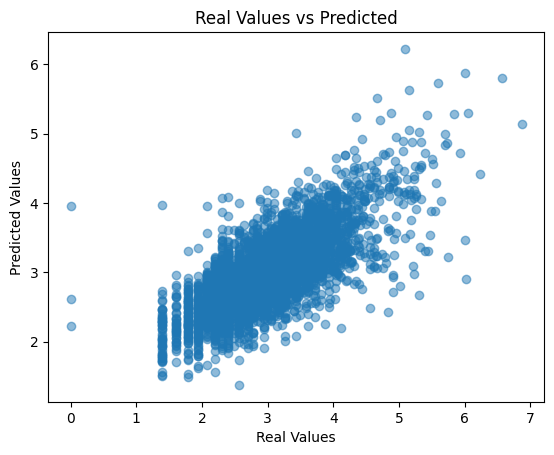

In [ ]:
# scatter plot for predictions
plt.scatter(y_test[:4000], ridge_preds[:4000], alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Real Values vs Predicted")
plt.show()

### With Label Encoder and W2V

In [ ]:
ridge_model_le = Ridge(solver = "auto", random_state=42)
ridge_model_le.fit(X_train_combined , y_train)

Ridge(random_state=42)

In [ ]:
X_train_combined.shape, y_train.shape

((1186028, 108), (1186028,))

In [ ]:
# validation set predictions
y_validation_pred_ridge = ridge_model_le.predict(X_validation_combined)

# we calculate the RMSE
rmse_validation = np.sqrt(mean_squared_error(y_validation, y_validation_pred_ridge))
print(f"RMSE Validation: {rmse_validation:.4f}")

RMSE Validation: 0.6297


In [ ]:
y_validation_pred_original = np.exp(y_validation_pred_ridge)

first_10_pred_prices = y_validation_pred_original[:10]

y_validation_original = np.exp(y_validation)

first_10_real_prices = y_validation_original[:10]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
382540         10.402707         7.0
386689         25.476692        25.0
616202         15.071810        13.0
51360          16.057297        15.0
538242         20.781965        14.0
1253857        28.982737        22.0
825801         23.785444        38.0
500310         24.152890        12.0
415445         23.757965        20.0
547087         12.937939        20.0


In [ ]:
parameters = {'alpha': np.logspace(-4, 1, 50)}  # da 0.0001 a 10

# Grid Search with Cross Validation
ridge_model_le_cv = GridSearchCV(ridge_model_le, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_model_le_cv.fit(X_train_combined, y_train)

# best parameter
best_alphaa = ridge_model_le_cv.best_params_['alpha']
print(f"Miglior Alpha: {best_alphaa}")

Miglior Alpha: 10.0


In [ ]:
# optimized model fit on the full training set
ridge_model_le = Ridge(alpha=best_alphaa, random_state=42, solver='auto')

In [ ]:
ridge_model_le.fit(X_train_combined, y_train)

# prediction on test set
y_test_pred = ridge_model_le.predict(X_test_combined)

# Calcolo dell'RMSE sul test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE Test: {rmse_test:.4f}")

test_mae = np.mean(np.abs(y_test_pred - y_test))
print(f"Test MAE: {test_mae}")

RMSE Test: 0.6306
Test MAE: 0.4819111607071779


In [ ]:
y_test_pred

array([3.42303813, 2.76668385, 3.0752178 , ..., 3.10639669, 3.41731548,
       2.675536  ])

In [ ]:
y_test_pred_original = np.exp(y_test_pred)

first_10_pred_prices = y_test_pred_original[:10]

y_test_original = np.exp(y_test)

first_10_real_prices = y_test_original[:10]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
14859          30.662430        23.0
1356518        15.905800         9.0
486687         21.654598        15.0
1188197        23.476800        17.0
151347         16.048419        19.0
899020         15.454814        19.0
1212506        16.035450        42.0
802776         42.533397        19.0
302139         11.847339        21.0
1102270        25.173873        11.0


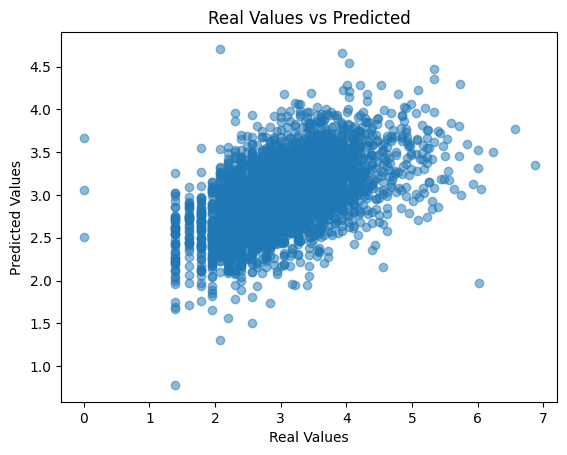

In [ ]:
# scatter plot for predictions
plt.scatter(y_test[:4000], y_test_pred[:4000], alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Real Values vs Predicted")
plt.show()

Even after the logarithmic transformation, the points should be close to the y=x bisector if the model is accurate.
However, the visible scatter suggests that the model may have difficulty capturing the logarithmic structure of the data in some price ranges.

## First Model

### With One-Hot Encoder, Tfidf and CV

The choice not to use sparse matrices with Keras neural networks, but only with regressive models, is based on several practical considerations:

* **Performance and Memory**: neural networks work best with dense data, while sparse matrices, although memory efficient, can slow down training and not make the most of the processing power of networks, which are optimized for continuous inputs.

* **Continuous Data in Neural Networks**: neural networks are designed to handle continuous and dense representations, such as those obtained by techniques such as Word2Vec. The use of sparse matrices (e.g. One-Hot, TF-IDF) limits the ability of the network to learn abstractions and interactions between variables.

* **Scalability and Generalization**: neural networks tend to generalize better with continuous data, while sparse matrices complicate learning and can lead to increased overfitting.

* **Compatibility with Regressive Models**: Regressive models such as logistic regression or decision trees can easily exploit sparse matrices, since these models treat each dimension separately and do not require interactions between features.

In summary, neural networks are more effective with dense representations, while regressive models are better suited to work with sparse data.

### With Label Encoder and W2V

In [ ]:
X_train_combined

array([[ 5.83988056e-02, -4.08343852e-01, -7.09476411e-01, ...,
         1.00000000e+00,  3.00000000e+00,  3.50000000e+01],
       [ 4.66396570e-01, -1.02809405e+00, -1.04388273e+00, ...,
         0.00000000e+00,  1.00000000e+00,  9.00000000e+00],
       [ 1.03228152e+00, -1.40001631e+00, -1.16137147e+00, ...,
         0.00000000e+00,  1.00000000e+00,  4.63000000e+02],
       ...,
       [ 1.22388721e+00, -5.76683402e-01, -6.73442841e-01, ...,
         0.00000000e+00,  1.00000000e+00,  9.70000000e+01],
       [ 1.72748077e+00, -2.22580329e-01,  7.83619761e-01, ...,
         0.00000000e+00,  1.00000000e+00,  1.80000000e+01],
       [ 1.37059247e+00, -1.34768641e+00, -8.97915959e-01, ...,
         1.00000000e+00,  1.00000000e+00,  5.78000000e+02]])

In [ ]:
model = Sequential()
input_shape = X_train_combined.shape[1]
inputs = Input(shape=(input_shape,), name="input_layer")
model.add(inputs)

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear', name="output_layer"))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, mode="min")
    # ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               55808     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

2025-01-26 14:14:31.118671: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
history_w2v = model.fit(
    X_train_combined, y_train,
    validation_data=(X_validation_combined, y_validation),
    epochs=10,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
2317/2317 [==============================] - 21s 9ms/step - loss: 0.9397 - mae: 0.6888 - val_loss: 0.4319 - val_mae: 0.5213
Epoch 2/10
2317/2317 [==============================] - 20s 9ms/step - loss: 0.4181 - mae: 0.4961 - val_loss: 0.3870 - val_mae: 0.4811
Epoch 3/10
2317/2317 [==============================] - 20s 9ms/step - loss: 0.3822 - mae: 0.4730 - val_loss: 0.3664 - val_mae: 0.4592
Epoch 4/10
2317/2317 [==============================] - 20s 9ms/step - loss: 0.3623 - mae: 0.4596 - val_loss: 0.3713 - val_mae: 0.4660
Epoch 5/10
2317/2317 [==============================] - 20s 9ms/step - loss: 0.3543 - mae: 0.4542 - val_loss: 0.3534 - val_mae: 0.4483
Epoch 6/10
2317/2317 [==============================] - 20s 9ms/step - loss: 0.3486 - mae: 0.4502 - val_loss: 0.3330 - val_mae: 0.4420
Epoch 7/10
2317/2317 [==============================] - 20s 9ms/step - loss: 0.3425 - mae: 0.4461 - val_loss: 0.3361 - val_mae: 0.4425
Epoch 8/10
2317/2317 [==============================] -

In [ ]:
history_dict = history_w2v.history

train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_mae = history_dict["mae"]
val_mae = history_dict["val_mae"]

# creation loss plot
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label="Training MAE", color="green")
plt.plot(val_mae, label="Validation MAE", color="red")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
nn1 = model.predict(X_test_combined, batch_size=512)

# Output
print("Predictions:", nn1)

290/290 [==============================] - 1s 2ms/step
Predictions: [[3.4449568]
 [3.0164413]
 [3.3924751]
 ...
 [3.1013043]
 [3.5448613]
 [2.5766666]]


In [ ]:
print("Shape of nn1:", nn1.shape)
print("Shape of y_test:", y_test.shape)

Shape of nn1: (148254, 1)
Shape of y_test: (148254,)


In [ ]:
nn1 = nn1.flatten()

In [ ]:
# we calculate the RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, nn1))
print(f"RMSE Test: {rmse_test:.4f}")

test_mae = np.mean(np.abs(nn1 - y_test))
print(f"Test MAE: {test_mae}")

RMSE Test: 0.6017
Test MAE: 0.46375399242928395


In [ ]:
# inverse (exponential) transformation of predictions
y_test_pred_original = np.exp(nn1)

# let's take the first ten predicted prices
first_10_pred_prices = y_test_pred_original[:10]

# inverse transformation of real prices
y_test_original = np.exp(y_test)

# let's take the first ten real prices
first_10_real_prices = y_test_original[:10]

first_10_pred_prices = [float(price[0]) if isinstance(price, (list, np.ndarray)) else float(price)
            for price in first_10_pred_prices]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
14859          31.341930        23.0
1356518        20.418499         9.0
486687         29.739470        15.0
1188197        35.193943        17.0
151347         18.368992        19.0
899020         24.473978        19.0
1212506        18.727154        42.0
802776         31.684307        19.0
302139         16.468317        21.0
1102270        18.002670        11.0


## Second Model

In [ ]:
# new optimizer with higher initial learning rate
optimizer = AdamW(learning_rate=0.01)

# we create an improved model
model2 = Sequential()

# Input Layer
input_shape = X_train_combined.shape[1]
inputs = Input(shape=(input_shape,), name="input_layer")
model2.add(inputs)

# first Hidden Layer
model2.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))  # Dropout più basso

# second Hidden Layer
model2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

# third Hidden Layer
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

# output Layer
model2.add(Dense(1, activation='linear', name="output_layer"))

model2.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Callback to reduce learning rate
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=0.0001)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True),
    lr_scheduler
]

In [ ]:
# Training
history2_w2v = model2.fit(
    X_train_combined, y_train,
    validation_data=(X_validation_combined, y_validation),
    epochs=20,  # reduce epochs to limit overfitting
    batch_size=1024,  # larger batch to stabilize training
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
  39/1159 [>.............................] - ETA: 13s - loss: 4.8036 - mae: 1.5205

1159/1159 [==============================] - 16s 13ms/step - loss: 0.7347 - mae: 0.5860 - val_loss: 0.4686 - val_mae: 0.4934 - lr: 0.0100
Epoch 2/20
1159/1159 [==============================] - 14s 12ms/step - loss: 0.4646 - mae: 0.5058 - val_loss: 0.5750 - val_mae: 0.6076 - lr: 0.0100
Epoch 3/20
1159/1159 [==============================] - 14s 12ms/step - loss: 0.4445 - mae: 0.5005 - val_loss: 0.4638 - val_mae: 0.5021 - lr: 0.0100
Epoch 4/20
1159/1159 [==============================] - 15s 13ms/step - loss: 0.4395 - mae: 0.4986 - val_loss: 0.4601 - val_mae: 0.5231 - lr: 0.0100
Epoch 5/20
1159/1159 [==============================] - 14s 12ms/step - loss: 0.4370 - mae: 0.4976 - val_loss: 0.5126 - val_mae: 0.5289 - lr: 0.0100
Epoch 6/20
1159/1159 [==============================] - 14s 12ms/step - loss: 0.4377 - mae: 0.4983 - val_loss: 5.0588 - val_mae: 2.0473 - lr: 0.0100
Epoch 7/20
1159/1159 [==============================] - 14s 12ms/step - loss: 0.4377 - mae: 0.4985 - val_loss: 0.4511

In [ ]:
nn2 = model2.predict(X_test_combined)

4633/4633 [==============================] - 4s 907us/step


In [ ]:
print("Shape of nn1:", nn2.shape)
print("Shape of y_test:", y_test.shape)

Shape of nn1: (148254, 1)
Shape of y_test: (148254,)


In [ ]:
nn2 = nn2.flatten()

In [ ]:
rmse_test = np.sqrt(mean_squared_error(y_test, nn2))
print(f"RMSE Test: {rmse_test:.4f}")

test_mae = np.mean(np.abs(nn2 - y_test))
print(f"Test MAE: {test_mae}")

RMSE Test: 0.6148
Test MAE: 0.46731438753225374


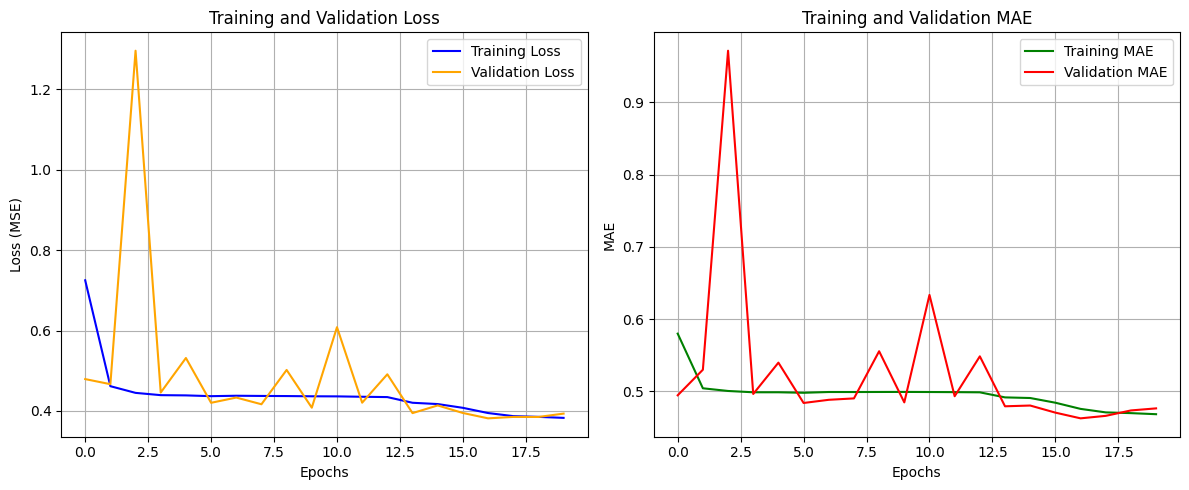

In [ ]:
history_dict = history2_w2v.history

train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_mae = history_dict["mae"]
val_mae = history_dict["val_mae"]

# creation loss plot
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label="Training MAE", color="green")
plt.plot(val_mae, label="Validation MAE", color="red")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# inverse (exponential) transformation of predictions
y_test_pred_original = np.exp(nn2)

# let's take the first ten predicted prices
first_10_pred_prices = y_test_pred_original[:10]

# inverse transformation of real prices
y_test_original = np.exp(y_test)

# let's take the first ten real prices
first_10_real_prices = y_test_original[:10]

first_10_pred_prices = [float(price[0]) if isinstance(price, (list, np.ndarray)) else float(price)
            for price in first_10_pred_prices]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
14859          28.935562        23.0
1356518        15.419250         9.0
486687         19.784893        15.0
1188197        20.667305        17.0
151347         15.656612        19.0
899020         16.094460        19.0
1212506        16.390509        42.0
802776         30.516500        19.0
302139         16.330687        21.0
1102270        19.528280        11.0


## Third Model

In [ ]:
# new model with more complexity
model3 = Sequential()

# input Layer
input_shape = X_train_combined.shape[1]
inputs = Input(shape=(input_shape,), name="input_layer")
model3.add(inputs)

# new model with more complexity
model3 = Sequential()

# input Layer
input_shape = X_train_combined.shape[1]
inputs = Input(shape=(input_shape,), name="input_layer")
model3.add(inputs)

# first Hidden Layer with regularization L2 e dropout
model3.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))  # Aumento del dropout per ridurre overfitting

# second Hidden Layer
model3.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

# third Hidden Layer
model3.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

# fourth Hidden Layer
model3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

# output Layer
model3.add(Dense(1, activation='linear', name="output_layer"))

optimizer = AdamW(learning_rate=0.001)

model3.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=0.00001)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True),
    lr_scheduler,
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
]

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2048      
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)              

In [ ]:
# Training
history3_w2v = model3.fit(
    X_train_combined, y_train,
    validation_data=(X_validation_combined, y_validation),
    epochs=25,
    batch_size=1024,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/25
1159/1159 [==============================] - 31s 25ms/step - loss: 1.6145 - mae: 0.8722 - val_loss: 0.4939 - val_mae: 0.4754 - lr: 0.0010
Epoch 2/25
   4/1159 [..............................] - ETA: 27s - loss: 0.6610 - mae: 0.5773

/home/MindHard/miniconda3/envs/AML/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1159/1159 [==============================] - 29s 25ms/step - loss: 0.5879 - mae: 0.5405 - val_loss: 0.4719 - val_mae: 0.4813 - lr: 0.0010
Epoch 3/25
1159/1159 [==============================] - 29s 25ms/step - loss: 0.5117 - mae: 0.5131 - val_loss: 0.4384 - val_mae: 0.4781 - lr: 0.0010
Epoch 4/25
1159/1159 [==============================] - 29s 25ms/step - loss: 0.4681 - mae: 0.5016 - val_loss: 0.4731 - val_mae: 0.4961 - lr: 0.0010
Epoch 5/25
1159/1159 [==============================] - 29s 25ms/step - loss: 0.4394 - mae: 0.4933 - val_loss: 0.3973 - val_mae: 0.4655 - lr: 0.0010
Epoch 6/25
1159/1159 [==============================] - 29s 25ms/step - loss: 0.4241 - mae: 0.4877 - val_loss: 0.4239 - val_mae: 0.4778 - lr: 0.0010
Epoch 7/25
1159/1159 [==============================] - 29s 25ms/step - loss: 0.4156 - mae: 0.4837 - val_loss: 0.4023 - val_mae: 0.4814 - lr: 0.0010
Epoch 8/25
1159/1159 [==============================] - 29s 25ms/step - loss: 0.4093 - mae: 0.4801 - val_loss: 0.3906

In [ ]:
nn3 = model3.predict(X_test_combined)

nn3 = nn3.flatten()

rmse_test = np.sqrt(mean_squared_error(y_test, nn3))
print(f"RMSE Test: {rmse_test:.4f}")

test_mae = np.mean(np.abs(nn3 - y_test))
print(f"Test MAE: {test_mae}")


4633/4633 [==============================] - 6s 1ms/step
RMSE Test: 0.5847
Test MAE: 0.447664864756096


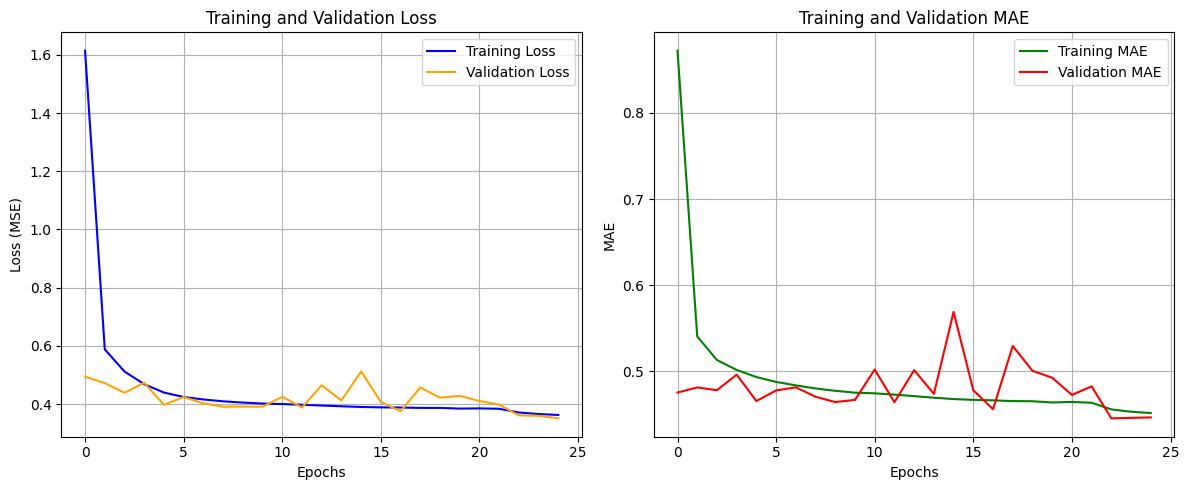

In [ ]:
history_dict = history3_w2v.history

train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_mae = history_dict["mae"]
val_mae = history_dict["val_mae"]

# creation loss plot
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label="Training MAE", color="green")
plt.plot(val_mae, label="Validation MAE", color="red")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# inverse (exponential) transformation of predictions
y_test_pred_original = np.exp(nn3)

# let's take the first ten predicted prices
first_10_pred_prices = y_test_pred_original[:10]

# inverse transformation of real prices
y_test_original = np.exp(y_test)

# let's take the first ten real prices
first_10_real_prices = y_test_original[:10]

first_10_pred_prices = [float(price[0]) if isinstance(price, (list, np.ndarray)) else float(price)
            for price in first_10_pred_prices]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
14859          31.638262        23.0
1356518        18.377466         9.0
486687         22.717234        15.0
1188197        26.245554        17.0
151347         16.027504        19.0
899020         14.386086        19.0
1212506        14.421464        42.0
802776         34.282036        19.0
302139         16.334768        21.0
1102270        19.206736        11.0


## Fourth Model

In [ ]:
model4_input = Input(shape=(X_train_combined.shape[1],), name="input_layer")

# dense network
dense_branch = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(model4_input)
dense_branch = BatchNormalization()(dense_branch)
dense_branch = Dropout(0.3)(dense_branch)

dense_branch = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(dense_branch)
dense_branch = BatchNormalization()(dense_branch)
dense_branch = Dropout(0.3)(dense_branch)

dense_branch = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(dense_branch)
dense_branch = BatchNormalization()(dense_branch)
dense_branch = Dropout(0.3)(dense_branch)

# GRU network (extracts temporal or sequential patterns)
gru_branch = Reshape((X_train_combined.shape[1], 1))(model4_input)  # Modifica dimensioni per GRU
gru_branch = GRU(128, return_sequences=True, kernel_regularizer=l2(0.0001))(gru_branch)
gru_branch = GRU(64, kernel_regularizer=l2(0.0001))(gru_branch)
gru_branch = Dropout(0.3)(gru_branch)

# concatenation of the two branches
merged = concatenate([dense_branch, gru_branch])

# final layer
output = Dense(1, activation='linear', name="output_layer")(merged)

model4 = Model(inputs=model4_input, outputs=output)

optimizer = AdamW(learning_rate=0.001)

model4.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=0.00001)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True),
    lr_scheduler,
    ModelCheckpoint("best_model4.h5", save_best_only=True, monitor="val_loss", mode="min")
]

model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 108)]                0         []                            
                                                                                                  
 dense_25 (Dense)            (None, 512)                  55808     ['input_layer[0][0]']         
                                                                                                  
 batch_normalization_23 (Ba  (None, 512)                  2048      ['dense_25[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 dropout_29 (Dropout)        (None, 512)                  0         ['batch_normalization_23[0

In [ ]:
history4_w2v = model4.fit(
    X_train_combined, y_train,
    validation_data=(X_validation_combined, y_validation),
    epochs=10,
    batch_size=1024,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
1159/1159 [==============================] - 626s 540ms/step - loss: 0.4203 - mae: 0.4828 - val_loss: 0.4100 - val_mae: 0.4896 - lr: 0.0010
Epoch 2/10
1159/1159 [==============================] - 626s 540ms/step - loss: 0.3929 - mae: 0.4704 - val_loss: 0.3564 - val_mae: 0.4458 - lr: 0.0010
Epoch 3/10
1159/1159 [==============================] - 625s 539ms/step - loss: 0.3699 - mae: 0.4580 - val_loss: 0.3407 - val_mae: 0.4355 - lr: 0.0010
Epoch 4/10
1159/1159 [==============================] - 623s 538ms/step - loss: 0.3559 - mae: 0.4504 - val_loss: 0.3529 - val_mae: 0.4410 - lr: 0.0010
Epoch 5/10
1159/1159 [==============================] - 624s 538ms/step - loss: 0.3444 - mae: 0.4429 - val_loss: 0.3294 - val_mae: 0.4347 - lr: 0.0010
Epoch 6/10
1159/1159 [==============================] - 624s 538ms/step - loss: 0.3348 - mae: 0.4368 - val_loss: 0.3227 - val_mae: 0.4262 - lr: 0.0010
Epoch 7/10
1159/1159 [==============================] - 623s 537ms/step - loss: 0.3274 - mae: 

In [ ]:
nn4 = model4.predict(X_test_combined)

nn4 = nn4.flatten()

rmse_test = np.sqrt(mean_squared_error(y_test, nn4))
print(f"RMSE Test: {rmse_test:.4f}")

test_mae = np.mean(np.abs(nn4 - y_test))
print(f"Test MAE: {test_mae}")

4633/4633 [==============================] - 98s 21ms/step
RMSE Test: 0.5547
Test MAE: 0.42453017442462265


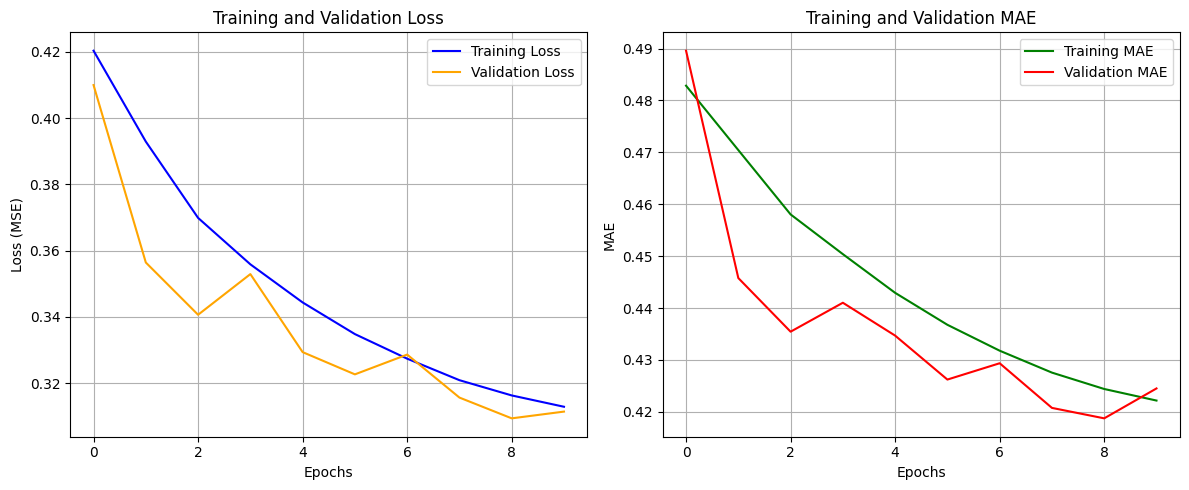

In [ ]:
history_dict = history4_w2v.history

train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_mae = history_dict["mae"]
val_mae = history_dict["val_mae"]

# creation loss plot
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label="Training MAE", color="green")
plt.plot(val_mae, label="Validation MAE", color="red")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# inverse (exponential) transformation of predictions
y_test_pred_original = np.exp(nn4)

# let's take the first ten predicted prices
first_10_pred_prices = y_test_pred_original[:10]

# inverse transformation of real prices
y_test_original = np.exp(y_test)

# let's take the first ten real prices
first_10_real_prices = y_test_original[:10]

first_10_pred_prices = [float(price[0]) if isinstance(price, (list, np.ndarray)) else float(price)
            for price in first_10_pred_prices]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
14859          16.316046        23.0
1356518        16.789236         9.0
486687         26.572990        15.0
1188197        23.174654        17.0
151347         20.503637        19.0
899020         19.216766        19.0
1212506        21.179068        42.0
802776         25.441366        19.0
302139         17.473591        21.0
1102270        23.098684        11.0


## Fifth Model

In [ ]:
X_train_reshaped = X_train_combined.reshape((X_train_combined.shape[0], 1, X_train_combined.shape[1]))
X_val_reshaped = X_validation_combined.reshape((X_validation_combined.shape[0], 1, X_validation_combined.shape[1]))
X_test_reshaped = X_test_combined.reshape((X_test_combined.shape[0], 1, X_test_combined.shape[1]))

In [ ]:
rnn = Sequential()
rnn.add(LSTM(units=128, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))  # Aggiungi return_sequences=True
rnn.add(Dropout(0.3))
rnn.add(LSTM(units=64, activation='relu', return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=32, activation='relu'))
rnn.add(Dropout(0.2))
rnn.add(Dense(1))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

rnn.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

In [ ]:
history_rnn = rnn.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_validation),
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=[lr_scheduler]
)

Epoch 1/20
18532/18532 [==============================] - 67s 3ms/step - loss: 2.2912 - mae: 0.8847 - val_loss: 0.5057 - val_mae: 0.5539 - lr: 1.0000e-04
Epoch 2/20
18532/18532 [==============================] - 63s 3ms/step - loss: 0.5027 - mae: 0.5447 - val_loss: 0.3917 - val_mae: 0.4782 - lr: 1.0000e-04
Epoch 3/20
18532/18532 [==============================] - 63s 3ms/step - loss: 0.4149 - mae: 0.4925 - val_loss: 0.3707 - val_mae: 0.4592 - lr: 1.0000e-04
Epoch 4/20
18532/18532 [==============================] - 62s 3ms/step - loss: 0.3904 - mae: 0.4772 - val_loss: 0.3571 - val_mae: 0.4539 - lr: 1.0000e-04
Epoch 5/20
18532/18532 [==============================] - 62s 3ms/step - loss: 0.3774 - mae: 0.4691 - val_loss: 0.3499 - val_mae: 0.4519 - lr: 1.0000e-04
Epoch 6/20
18532/18532 [==============================] - 62s 3ms/step - loss: 0.3690 - mae: 0.4636 - val_loss: 0.3440 - val_mae: 0.4460 - lr: 1.0000e-04
Epoch 7/20
18532/18532 [==============================] - 62s 3ms/step - los

In [ ]:
y_pred_rnn = rnn.predict(X_test_reshaped)

y_pred_conv = y_pred_rnn.flatten()

test_rmse = np.sqrt(np.mean(np.square(y_pred_conv - y_test)))
print(f"Test RMSE: {test_rmse}")

test_mae = np.mean(np.abs(y_pred_conv - y_test))
print(f"Test MAE: {test_mae}")

1012/4633 [=====>........................] - ETA: 4s

4633/4633 [==============================] - 6s 1ms/step
Test RMSE: 0.5728574163828107
Test MAE: 0.43879577218754595


In [ ]:
# inverse (exponential) transformation of predictions
y_test_pred_original = np.exp(y_pred_rnn)

# let's take the first ten predicted prices
first_10_pred_prices = y_test_pred_original[:10]

# inverse transformation of real prices
y_test_original = np.exp(y_test)

# let's take the first ten real prices
first_10_real_prices = y_test_original[:10]

first_10_pred_prices = [float(price[0]) if isinstance(price, (list, np.ndarray)) else float(price)
            for price in first_10_pred_prices]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
14859          29.250782        23.0
1356518        19.010366         9.0
486687         22.046997        15.0
1188197        24.465235        17.0
151347         16.940519        19.0
899020         22.100513        19.0
1212506        17.906906        42.0
802776         25.747555        19.0
302139         15.512410        21.0
1102270        19.697517        11.0


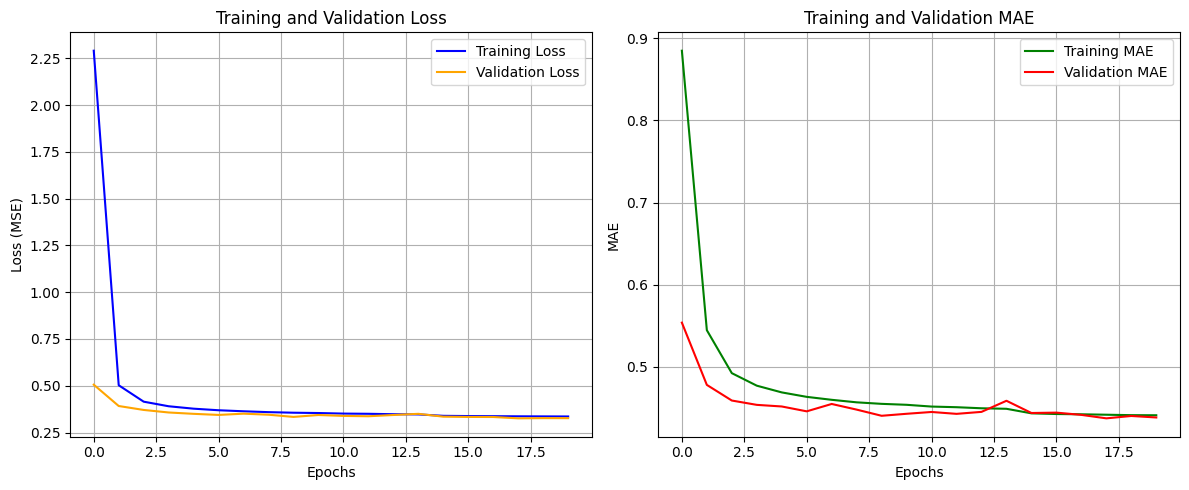

In [ ]:
history_dict = history_rnn.history

train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_mae = history_dict["mae"]
val_mae = history_dict["val_mae"]

# creation loss plot
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label="Training MAE", color="green")
plt.plot(val_mae, label="Validation MAE", color="red")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Ensembling


In [ ]:
class ModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, is_rnn=False):
        self.model = model
        self.is_rnn = is_rnn

    def fit(self, X, y, **kwargs):
        if self.is_rnn and len(X.shape) == 2:
            X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape for RNN
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X, **kwargs):
        if self.is_rnn and len(X.shape) == 2:
            X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape for RNN
        return self.model.predict(X, **kwargs)


In [ ]:
ridge_model_wrapped = ModelWrapper(ridge_model_le, is_rnn=False)
nn_wrapped = ModelWrapper(model4, is_rnn=False)
rnn_model_wrapped = ModelWrapper(rnn, is_rnn=True)

stacking_model = StackingRegressor(
    estimators=[
        ('ridge', ridge_model_wrapped),
        ('nn', nn_wrapped),
        ('rnn', rnn_model_wrapped)
    ],
    final_estimator=LinearRegression()
)

stacking_model.fit(X_train_combined, y_train)

7413/7413 [==============================] - 9s 1ms/step


StackingRegressor(estimators=[('ridge',
                               ModelWrapper(model=Ridge(alpha=10.0,
                                                        random_state=42))),
                              ('nn',
                               ModelWrapper(model=<keras.src.engine.functional.Functional object at 0x7635c6175090>)),
                              ('rnn',
                               ModelWrapper(is_rnn=True,
                                            model=<keras.src.engine.sequential.Sequential object at 0x76366c7aa170>))],
                  final_estimator=LinearRegression())

In [ ]:
# predictions
stacked_preds = stacking_model.predict(X_test_combined)

4633/4633 [==============================] - 6s 1ms/step


In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, stacked_preds))
print(f"Stacking Model RMSE: {rmse:.4f}")

test_mae = np.mean(np.abs(nn4 - y_test))
print(f"Stacking Model MAE: {test_mae}")

Stacking Model RMSE: 0.5510
Stacking Model MAE: 0.42453017442462265


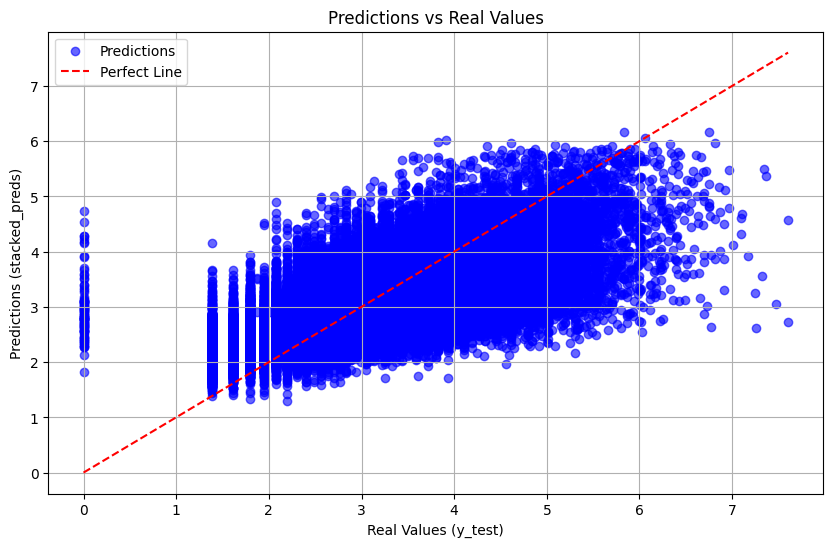

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, stacked_preds, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Line')
plt.title("Predictions vs Real Values")
plt.xlabel("Real Values (y_test)")
plt.ylabel("Predictions (stacked_preds)")
plt.legend()
plt.grid()
plt.show()

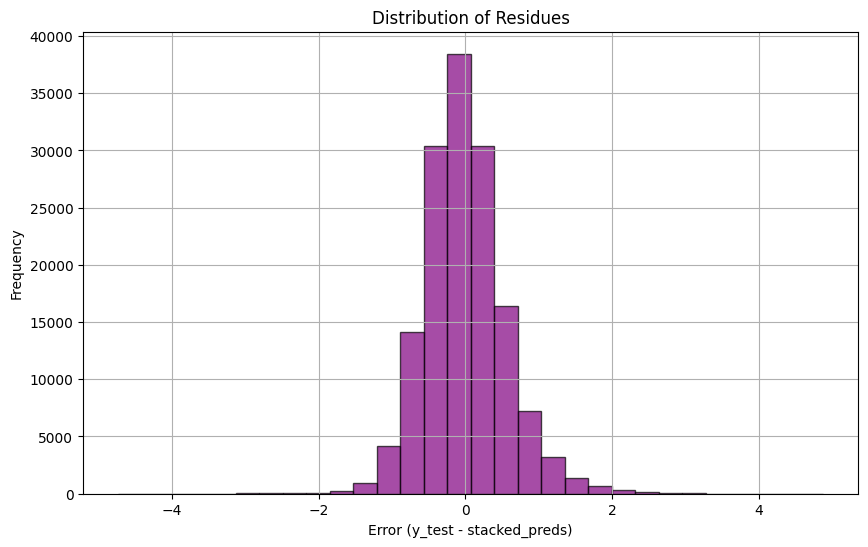

In [ ]:
residuals = y_test - stacked_preds

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title("Distribution of Residues")
plt.xlabel("Error (y_test - stacked_preds)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Real Values', color='blue')
plt.plot(range(len(stacked_preds)), stacked_preds, label='Predictions', color='orange', alpha=0.8)
plt.title("Actual Values ​​Trend vs Predictions")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# inverse (exponential) transformation of predictions
y_test_pred_original = np.exp(stacked_preds)

# let's take the first ten predicted prices
first_10_pred_prices = y_test_pred_original[:10]

# inverse transformation of real prices
y_test_original = np.exp(y_test)

# let's take the first ten real prices
first_10_real_prices = y_test_original[:10]

first_10_pred_prices = [float(price[0]) if isinstance(price, (list, np.ndarray)) else float(price)
            for price in first_10_pred_prices]

comparison_df = pd.DataFrame({
    'Predicted Price': first_10_pred_prices,
    'Real Price': first_10_real_prices
})

print(comparison_df)

         Predicted Price  Real Price
14859          23.941739        23.0
1356518        18.884437         9.0
486687         25.256915        15.0
1188197        30.777580        17.0
151347         15.467831        19.0
899020         22.485490        19.0
1212506        19.728796        42.0
802776         20.516806        19.0
302139         15.102094        21.0
1102270        23.219587        11.0


# Eli5 & Lime

In [ ]:
anna_path = '/content/drive/MyDrive/Magistrale/2°anno/Advanced ML/Advanced Machine Learning/train.tsv'
fra_path = 'train.tsv'
#fra_path = '/content/drive/MyDrive/Advanced Machine Learning/train.tsv'
max_path = ''

if os.path.exists(anna_path):
    train = pd.read_csv(anna_path, sep='\t')
elif os.path.exists(fra_path):
    train = pd.read_csv(fra_path, sep='\t')
elif os.path.exists(max_path):
    train = pd.read_csv(max_path, sep='\t')
else:
    print("File not found")

In [ ]:
y_train = np.log1p(train['price'])
train['category_name'] = train['category_name'].fillna('Other').astype(str)
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
train['shipping'] = train['shipping'].astype(str)
train['item_condition_id'] = train['item_condition_id'].astype(str)
train['item_description'] = train['item_description'].fillna('None')

In [ ]:
train.head()

train_id                                 name item_condition_id   
0         0  MLB Cincinnati Reds T Shirt Size XL                 3  \
1         1     Razer BlackWidow Chroma Keyboard                 3   
2         2                       AVA-VIV Blouse                 1   
3         3                Leather Horse Statues                 1   
4         4                 24K GOLD plated rose                 1   

                                       category_name brand_name  price   
0                                  Men/Tops/T-shirts    missing   10.0  \
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents    missing   35.0   
4                            Women/Jewelry/Necklaces    missing   44.0   

  shipping                                   item_description  
0        1                                 No description yet  
1        0  This keyboard is in great condition and works ...  
2        1  Adorable top with a hint of lace and a key hol...  
3        1  New with tags. Leather horses. Retail for [rm]...  
4        0          Complete with certificate of authenticity

In [ ]:
# we need a custom pre-processor to extract correct field,
# but want to also use default scikit-learn preprocessing (e.g. lowercasing)
default_preprocessor = CountVectorizer().build_preprocessor()

def build_preprocessor(field):
    field_idx = list(train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=100000,
        preprocessor=build_preprocessor('item_description'))),
])

X_train = vectorizer.fit_transform(train.values)
X_train

<1482535x156105 sparse matrix of type '<class 'numpy.float64'>'
	with 74565034 stored elements in Compressed Sparse Row format>

In [ ]:
X_train.shape

(1482535, 156105)

## Ridge Regression

In [ ]:
def get_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def get_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train):
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)
    model.fit(X_train[train_ids], y_train[train_ids])
    y_pred_valid = model.predict(X_train[valid_ids])

    mae = get_mae(y_train[valid_ids], y_pred_valid)
    rmse = get_rmse(y_train[valid_ids], y_pred_valid)

    print(f'valid mae: {mae:.5f}')
    print(f'valid rmse: {rmse:.5f}')
    break

/home/MindHard/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


valid mae: 0.37227
valid rmse: 0.49569


In [ ]:
eli5.show_weights(model, vec=vectorizer)

/home/MindHard/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
eli5.show_prediction(model, doc=train.values[100], vec=vectorizer)

/home/MindHard/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
eli5.show_prediction(model, doc=train.values[1], vec=vectorizer)

/home/MindHard/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
eli5.explain_prediction_df(model, doc=train.values[100], vec=vectorizer)


/home/MindHard/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


target                                       feature    weight     value
0       y                                        <BIAS>  2.631789  1.000000
1       y                                   shipping__0  0.105350  1.000000
2       y                          item_condition_id__3  0.102351  1.000000
3       y                        item_description__with  0.048598  0.126853
4       y                        item_description__this  0.019527  0.057055
..    ...                                           ...       ...       ...
68      y                       item_description__holes -0.015673  0.097204
69      y                          item_description__or -0.018684  0.165456
70      y  category_name__women/tops & blouses/t-shirts -0.095653  1.000000
71      y                           brand_name__missing -0.122067  1.000000
72      y                                   name__shirt -0.163888  1.000000

[73 rows x 4 columns]

## NN Third Model

In [ ]:
type(X_train)

scipy.sparse._csr.csr_matrix

In [ ]:
if isinstance(X_train, csr_matrix):
    indices = np.vstack(X_train.nonzero()).T
    values = X_train.data
    shape = X_train.shape
    X_train_sparse = tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=shape)
else:
    X_train_sparse = tf.sparse.from_dense(X_train)


X_train_sparse = tf.sparse.reorder(X_train_sparse)

y_train = np.array(y_train)

input_shape = X_train.shape[1]
inputs = Input(shape=(input_shape,), sparse=True)

model3 = Sequential()
model3.add(inputs)

model3.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(1, activation='linear', name="output_layer"))

optimizer = AdamW(learning_rate=0.001)

model3.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=0.00001)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True),
    lr_scheduler,
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
]

model3.summary()

history3_w2v = model3.fit(
    X_train_sparse, y_train,
    epochs=10,
    batch_size=1024,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 1024)              159852544 
                                                                 
 batch_normalization_36 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_38 (Dropout)        (None, 1024)              0         
                                                                 
 dense_41 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_37 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_39 (Dropout)        (None, 512)             

In [ ]:
X_train_sparse

SparseTensor(indices=tf.Tensor(
[[      0   10225]
 [      0   10227]
 [      0   28559]
 ...
 [1482534  151849]
 [1482534  152790]
 [1482534  152834]], shape=(74565034, 2), dtype=int64), values=tf.Tensor([1.         1.         1.         ... 0.18015708 0.38216325 0.21719244], shape=(74565034,), dtype=float64), dense_shape=tf.Tensor([1482535  156105], shape=(2,), dtype=int64))

In [ ]:
X_train_csr = sp.csr_matrix((X_train_sparse.values.numpy(),
                              (X_train_sparse.indices.numpy()[:, 0], X_train_sparse.indices.numpy()[:, 1])),
                             shape=X_train_sparse.dense_shape)

subset_idx = np.random.choice(X_train_csr.shape[0], 100, replace=False)
X_train_subset = X_train_csr[subset_idx]

explainer = LimeTabularExplainer(
    X_train_subset.toarray(),
    feature_names=[f"Feature {i}" for i in range(X_train_csr.shape[1])],
    mode="regression"
)

idx = 0
exp = explainer.explain_instance(X_train_subset[idx].toarray()[0], model3.predict)

exp.show_in_notebook()

157/157 [==============================] - 22s 141ms/step


In [ ]:
feature_names = vectorizer.get_feature_names_out()

In [ ]:
feature_names

array(['name__00', 'name__00 carat', 'name__000', ...,
       'item_description__ʏᴏᴜ', 'item_description__ғʀᴇᴇ',
       'item_description__ᴛᴏ'], dtype=object)

In [ ]:
feature_mapping = {i: word for i, word in enumerate(feature_names)}

explanation = exp.as_list()  # Ottieni il ranking delle feature
explanation_interpretable = [(feature_mapping[int(f.split()[1])], score) for f, score in explanation]

for feature, importance in explanation_interpretable:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: category_name__electronics/video games & consoles/consoles, Importance: -0.7049351346719758
Feature: brand_name__kendra scott, Importance: -0.6921461416368392
Feature: brand_name__tory burch, Importance: -0.43603106799789415
Feature: name__14k, Importance: 0.4294470698647259
Feature: category_name__electronics/cell phones & accessories/screen protectors, Importance: 0.3099157815344939
Feature: name__james avery, Importance: -0.3041774206169453
Feature: name__bundle, Importance: -0.2977226046597672
Feature: category_name__kids/boys (4+)/shoes, Importance: -0.2785859327793466
Feature: brand_name__forever 21, Importance: 0.2770621379326102
Feature: name__carly, Importance: -0.2026309467799061


In [ ]:
explainer = LimeTabularExplainer(
    X_train_subset.toarray(),
    feature_names=feature_names,  # Usa il vocabolario
    mode="regression"
)
exp = explainer.explain_instance(X_train_subset[idx].toarray()[0], model3.predict)


157/157 [==============================] - 22s 142ms/step


In [ ]:
exp.show_in_notebook()